<h2><b>Build a Prefect Workflow and Auto Schedule it. Show the Prefect Dashboard with relevant outputs</b></h2>

I have established a virtual environment named ".env" and installed the "Prefect" library within it.

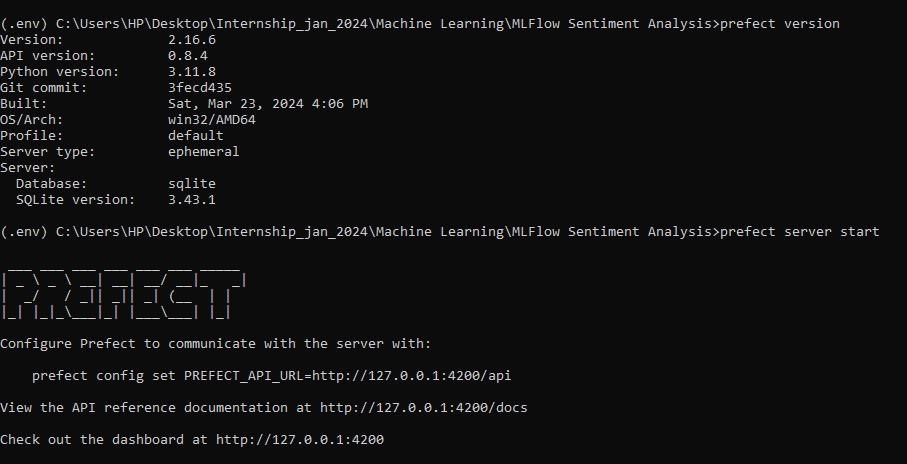

In [2]:
from IPython.display import Image

Image('screen/Prefect/cmd.png')

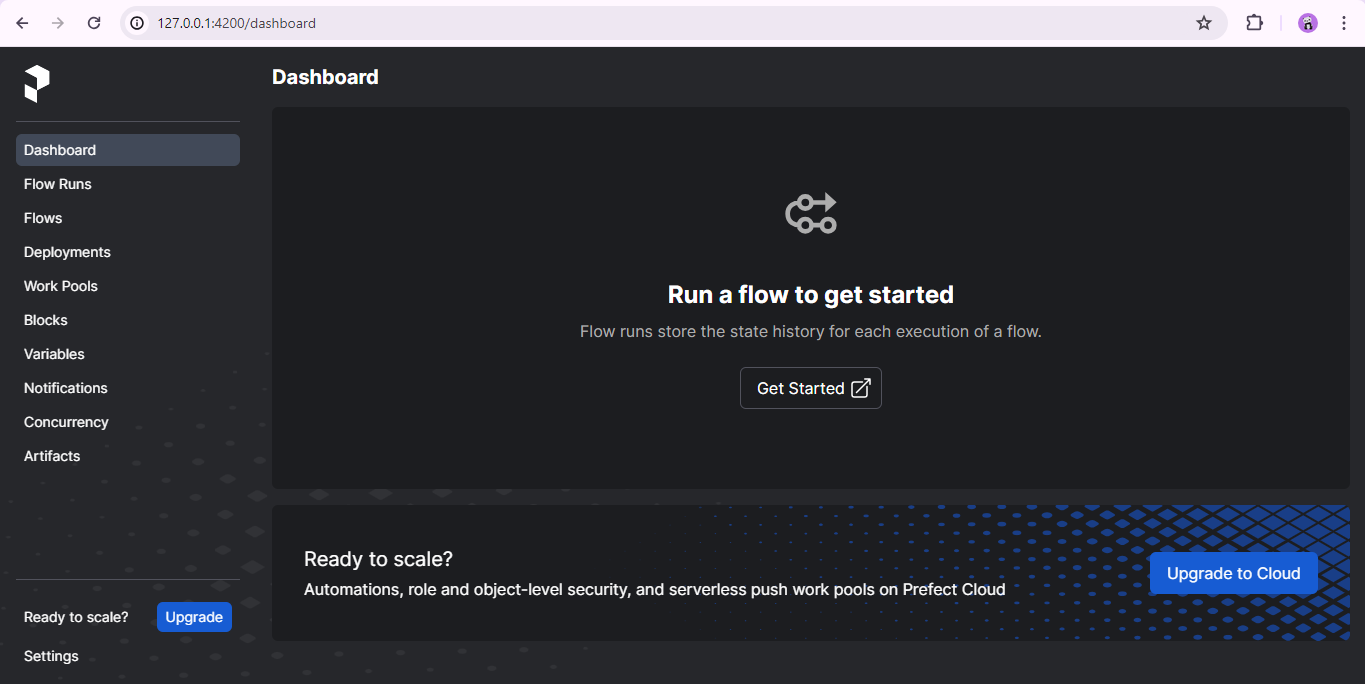

In [3]:
Image('screen/Prefect/Prefect.png')

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn import metrics

In [5]:
def load_data(file_path):
    """
    Load data from a CSV file.
    """
    return pd.read_csv(file_path)

In [6]:
def drop_columns(df, columns_to_drop):
    """
    Drop specified columns from the DataFrame inplace.
    
    """
    df.drop(columns=columns_to_drop, inplace=True)

In [7]:
def remove_nan_values(df):
    """
    Check for NaN values in the DataFrame and remove all rows with NaN values inplace.
        
    """
    nan_values_count = df.isnull().sum().sum()
    if nan_values_count > 0:
        print("NaN values detected. Removing rows with NaN values.")
        # Remove all rows with NaN values
        df.dropna(inplace=True)
    else:
        print("No NaN values detected.")

In [8]:
def create_sentiment_labels(df, threshold=4, column='Ratings'):
    """
    Create sentiment labels based on a threshold for positive/negative ratings inplace.
    
    """
    # Create sentiment labels
    df[column] = df[column].apply(lambda x: 'Positive' if x >= threshold else 'Negative')

In [9]:
def split_features_target(dataframe, INPUTS, OUTPUT):
    """
    Split the DataFrame into input features (X) and target variable (y).
    
    """
    X = dataframe[INPUTS]
    y = dataframe[OUTPUT]
    return X, y

In [10]:
def split_train_test(X, y, train_size=0.75, random_state=0):
    """
    Split the data into training and testing sets.
    
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [11]:
def preprocess(text):
    """
    Preprocess text data by removing 'READ MORE', special characters, punctuation, stopwords,
    and converting text to lowercase, followed by lemmatization.
    
    """
    # Remove 'READ MORE'
    text = text.replace('READ MORE', '')
    
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    clean_text = ' '.join(tokens)
    
    return clean_text

In [12]:
def feature_engineering(X_train_clean, X_test_clean, vectorizer_type, max_features):
    """
    Perform feature engineering using CountVectorizer or TfidfVectorizer.
    
    """
    if vectorizer_type == 'count':
        vectorizer = CountVectorizer(max_features=max_features)
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features)
    else:
        raise ValueError("Invalid vectorizer_type. Please choose 'count' or 'tfidf'.")
    
    # Fit and transform the training data
    X_train_vectorized = vectorizer.fit_transform(X_train_clean)
    
    # Transform the test data
    X_test_vectorized = vectorizer.transform(X_test_clean)
    
    return X_train_vectorized, X_test_vectorized


In [13]:
def train_model(X_train_vectorized, y_train, hyperparameters):
    """
    Train a machine learning model.
    
    """
    # Create the classifier with specified hyperparameters
    clf = SVC(**hyperparameters)
    
    # Train the model
    clf.fit(X_train_vectorized, y_train)
    
    return clf


In [14]:
def evaluate_model(model, X_train_vectorized, y_train, X_test_vectorized, y_test):
    """
    Evaluate the trained model.
    
    """
    # Predictions on training and test sets
    y_train_pred = model.predict(X_train_vectorized)
    y_test_pred = model.predict(X_test_vectorized)

    # Calculate accuracy scores
    train_score = metrics.accuracy_score(y_train, y_train_pred)
    test_score = metrics.accuracy_score(y_test, y_test_pred)
    
    return train_score, test_score


In [15]:
def workflow():
    DATA_PATH = 'reviews_badminton/data.csv'
    columns_to_drop=['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes', 'Down Votes', 'Month']
    INPUTS = 'Review text'
    OUTPUT = 'Ratings'
    max_features = 5000
    vectorizer_type = 'tfidf' #CountVectorizer == 'count'  TfidfVectorizer == 'tfidf'
    hyperparameters = {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}
    
    # Load data
    df = load_data(DATA_PATH)
    
    # Dropping columns
    drop_columns(df, columns_to_drop)
    
    # Removing NaN Values
    remove_nan_values(df)
    
    # Created sentiment labels
    create_sentiment_labels(df)

    # Identify Inputs and Output
    X, y = split_features_target(df, INPUTS, OUTPUT)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = split_train_test(X, y)
    
    # Preprocess the data
    X_train_clean = X_train.apply(preprocess)
    X_test_clean = X_test.apply(preprocess)

    # Apply feature engineering
    X_train_vectorized, X_test_vectorized = feature_engineering(X_train_clean, X_test_clean, vectorizer_type, max_features)
    
    # Build a model
    model = train_model(X_train_vectorized, y_train, hyperparameters)
    
    # Evaluate the model
    train_score, test_score = evaluate_model(model, X_train_vectorized, y_train, X_test_vectorized, y_test)

    # Print the evaluation scores
    print("Train Score:", train_score)
    print("Test Score:", test_score)
    

In [16]:
if __name__ == "__main__":
    workflow()

NaN values detected. Removing rows with NaN values.
Train Score: 0.9512691946098402
Test Score: 0.8759398496240601


<h2><b>Building a Prefect Workflow</b></h2>


<h4><b>Import Prefect modules</b></h4>

In [17]:
from prefect import task, flow

<h4><b>Define Prefect Tasks</b></h4>

In [18]:
@task
def load_data(file_path):
    """
    Load data from a CSV file.
    """
    return pd.read_csv(file_path)

@task
def drop_columns(df, columns_to_drop):
    """
    Drop specified columns from the DataFrame inplace.
    
    """
    df.drop(columns=columns_to_drop, inplace=True)
    
@task
def remove_nan_values(df):
    """
    Check for NaN values in the DataFrame and remove all rows with NaN values inplace.
        
    """
    nan_values_count = df.isnull().sum().sum()
    if nan_values_count > 0:
        print("NaN values detected. Removing rows with NaN values.")
        # Remove all rows with NaN values
        df.dropna(inplace=True)
    else:
        print("No NaN values detected.")

@task
def create_sentiment_labels(df, threshold=4, column='Ratings'):
    """
    Create sentiment labels based on a threshold for positive/negative ratings inplace.
    
    """
    # Create sentiment labels
    df[column] = df[column].apply(lambda x: 'Positive' if x >= threshold else 'Negative')

@task
def split_features_target(dataframe, INPUTS, OUTPUT):
    """
    Split the DataFrame into input features (X) and target variable (y).
    
    """
    X = dataframe[INPUTS]
    y = dataframe[OUTPUT]
    return X, y

@task
def split_train_test(X, y, train_size=0.75, random_state=0):
    """
    Split the data into training and testing sets.
    
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

@task
def preprocess(text):
    """
    Preprocess text data by removing 'READ MORE', special characters, punctuation, stopwords,
    and converting text to lowercase, followed by lemmatization.
    
    """
    # Remove 'READ MORE'
    text = text.replace('READ MORE', '')
    
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    clean_text = ' '.join(tokens)
    
    return clean_text

@task
def feature_engineering(X_train_clean, X_test_clean, vectorizer_type, max_features):
    """
    Perform feature engineering using CountVectorizer or TfidfVectorizer.
    
    """
    if vectorizer_type == 'count':
        vectorizer = CountVectorizer(max_features=max_features)
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features)
    else:
        raise ValueError("Invalid vectorizer_type. Please choose 'count' or 'tfidf'.")
    
    # Fit and transform the training data
    X_train_vectorized = vectorizer.fit_transform(X_train_clean)
    
    # Transform the test data
    X_test_vectorized = vectorizer.transform(X_test_clean)
    
    return X_train_vectorized, X_test_vectorized

@task
def train_model(X_train_vectorized, y_train, hyperparameters):
    """
    Train a machine learning model.
    
    """
    # Create the classifier with specified hyperparameters
    clf = SVC(**hyperparameters)
    
    # Train the model
    clf.fit(X_train_vectorized, y_train)
    
    return clf

@task
def evaluate_model(model, X_train_vectorized, y_train, X_test_vectorized, y_test):
    """
    Evaluate the trained model.
    
    """
    # Predictions on training and test sets
    y_train_pred = model.predict(X_train_vectorized)
    y_test_pred = model.predict(X_test_vectorized)

    # Calculate accuracy scores
    train_score = metrics.accuracy_score(y_train, y_train_pred)
    test_score = metrics.accuracy_score(y_test, y_test_pred)
    
    return train_score, test_score

<h4><b>Define Prefect Flow</b></h4>

In [19]:
import joblib
from joblib import Memory

# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

@flow(name="Sentiment Analysis - SVC")
def workflow():
    DATA_PATH = 'reviews_badminton/data.csv'
    columns_to_drop=['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes', 'Down Votes', 'Month']
    INPUTS = 'Review text'
    OUTPUT = 'Ratings'
    max_features = 5000
    vectorizer_type = 'tfidf' #CountVectorizer == 'count'  TfidfVectorizer == 'tfidf'
    hyperparameters = {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}
    
    # Load data
    df = load_data(DATA_PATH)
    
    # Dropping columns
    drop_columns(df, columns_to_drop)
    
    # Removing NaN Values
    remove_nan_values(df)
    
    # Created sentiment labels
    create_sentiment_labels(df)

    # Identify Inputs and Output
    X, y = split_features_target(df, INPUTS, OUTPUT)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = split_train_test(X, y)
    
    # Preprocess the data
    X_train_clean = X_train.apply(preprocess)
    X_test_clean = X_test.apply(preprocess)

    # Apply feature engineering
    X_train_vectorized, X_test_vectorized = feature_engineering(X_train_clean, X_test_clean, vectorizer_type, max_features)
    
    # Build a model
    model = train_model(X_train_vectorized, y_train, hyperparameters)
    
    # Evaluate the model
    train_score, test_score = evaluate_model(model, X_train_vectorized, y_train, X_test_vectorized, y_test)

    # Print the evaluation scores
    print("Train Score:", train_score)
    print("Test Score:", test_score)
    

In [20]:
import joblib
from joblib import Memory

# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

if __name__ == "__main__":
    workflow()

17:29:54.136 | INFO    | prefect.engine - Created flow run 'translucent-vole' for flow 'Sentiment Analysis - SVC'

17:29:56.444 | INFO    | Flow run 'translucent-vole' - Created task run 'load_data-0' for task 'load_data'

17:29:56.496 | INFO    | Flow run 'translucent-vole' - Executing 'load_data-0' immediately...

17:29:58.775 | INFO    | Task run 'load_data-0' - Finished in state Completed()

17:29:59.517 | INFO    | Flow run 'translucent-vole' - Created task run 'drop_columns-0' for task 'drop_columns'

17:29:59.521 | INFO    | Flow run 'translucent-vole' - Executing 'drop_columns-0' immediately...

17:30:01.562 | INFO    | Task run 'drop_columns-0' - Finished in state Completed()

17:30:02.023 | INFO    | Flow run 'translucent-vole' - Created task run 'remove_nan_values-0' for task 'remove_nan_values'

17:30:02.030 | INFO    | Flow run 'translucent-vole' - Executing 'remove_nan_values-0' immediately...

NaN values detected. Removing rows with NaN values.


17:30:04.501 | INFO    | Task run 'remove_nan_values-0' - Finished in state Completed()

17:30:05.288 | INFO    | Flow run 'translucent-vole' - Created task run 'create_sentiment_labels-0' for task 'create_sentiment_labels'

17:30:05.295 | INFO    | Flow run 'translucent-vole' - Executing 'create_sentiment_labels-0' immediately...

17:30:07.164 | INFO    | Task run 'create_sentiment_labels-0' - Finished in state Completed()

17:30:07.890 | INFO    | Flow run 'translucent-vole' - Created task run 'split_features_target-0' for task 'split_features_target'

17:30:07.894 | INFO    | Flow run 'translucent-vole' - Executing 'split_features_target-0' immediately...

17:30:09.618 | INFO    | Task run 'split_features_target-0' - Finished in state Completed()

17:30:10.653 | INFO    | Flow run 'translucent-vole' - Created task run 'split_train_test-0' for task 'split_train_test'

17:30:10.656 | INFO    | Flow run 'translucent-vole' - Executing 'split_train_test-0' immediately...

17:30:12.547 | INFO    | Task run 'split_train_test-0' - Finished in state Completed()

17:30:13.385 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-0' for task 'preprocess'

17:30:13.388 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-0' immediately...

17:30:15.337 | INFO    | Task run 'preprocess-0' - Finished in state Completed()

17:30:16.080 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-1' for task 'preprocess'

17:30:16.085 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-1' immediately...

17:30:18.032 | INFO    | Task run 'preprocess-1' - Finished in state Completed()

17:30:18.457 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-2' for task 'preprocess'

17:30:18.461 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-2' immediately...

17:30:20.360 | INFO    | Task run 'preprocess-2' - Finished in state Completed()

17:30:20.722 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-3' for task 'preprocess'

17:30:20.724 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-3' immediately...

17:30:23.159 | INFO    | Task run 'preprocess-3' - Finished in state Completed()

17:30:23.504 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-4' for task 'preprocess'

17:30:23.512 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-4' immediately...

17:30:25.398 | INFO    | Task run 'preprocess-4' - Finished in state Completed()

17:30:25.787 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-5' for task 'preprocess'

17:30:25.791 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-5' immediately...

17:30:27.591 | INFO    | Task run 'preprocess-5' - Finished in state Completed()

17:30:28.521 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-6' for task 'preprocess'

17:30:28.532 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-6' immediately...

17:30:30.509 | INFO    | Task run 'preprocess-6' - Finished in state Completed()

17:30:31.216 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-7' for task 'preprocess'

17:30:31.225 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-7' immediately...

17:30:33.163 | INFO    | Task run 'preprocess-7' - Finished in state Completed()

17:30:33.995 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-8' for task 'preprocess'

17:30:33.997 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-8' immediately...

17:30:35.839 | INFO    | Task run 'preprocess-8' - Finished in state Completed()

17:30:36.569 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-9' for task 'preprocess'

17:30:36.576 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-9' immediately...

17:30:38.246 | INFO    | Task run 'preprocess-9' - Finished in state Completed()

17:30:39.014 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-10' for task 'preprocess'

17:30:39.021 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-10' immediately...

17:30:40.753 | INFO    | Task run 'preprocess-10' - Finished in state Completed()

17:30:41.715 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-11' for task 'preprocess'

17:30:41.724 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-11' immediately...

17:30:43.739 | INFO    | Task run 'preprocess-11' - Finished in state Completed()

17:30:44.379 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-12' for task 'preprocess'

17:30:44.389 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-12' immediately...

17:30:46.368 | INFO    | Task run 'preprocess-12' - Finished in state Completed()

17:30:47.064 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-13' for task 'preprocess'

17:30:47.074 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-13' immediately...

17:30:48.720 | INFO    | Task run 'preprocess-13' - Finished in state Completed()

17:30:49.479 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-14' for task 'preprocess'

17:30:49.484 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-14' immediately...

17:30:51.303 | INFO    | Task run 'preprocess-14' - Finished in state Completed()

17:30:52.026 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-15' for task 'preprocess'

17:30:52.030 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-15' immediately...

17:30:53.734 | INFO    | Task run 'preprocess-15' - Finished in state Completed()

17:30:54.462 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-16' for task 'preprocess'

17:30:54.473 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-16' immediately...

17:30:56.112 | INFO    | Task run 'preprocess-16' - Finished in state Completed()

17:30:56.820 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-17' for task 'preprocess'

17:30:56.830 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-17' immediately...

17:30:58.609 | INFO    | Task run 'preprocess-17' - Finished in state Completed()

17:30:59.568 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-18' for task 'preprocess'

17:30:59.579 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-18' immediately...

17:31:01.267 | INFO    | Task run 'preprocess-18' - Finished in state Completed()

17:31:02.174 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-19' for task 'preprocess'

17:31:02.184 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-19' immediately...

17:31:03.889 | INFO    | Task run 'preprocess-19' - Finished in state Completed()

17:31:04.628 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-20' for task 'preprocess'

17:31:04.632 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-20' immediately...

17:31:06.351 | INFO    | Task run 'preprocess-20' - Finished in state Completed()

17:31:07.042 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-21' for task 'preprocess'

17:31:07.048 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-21' immediately...

17:31:08.503 | INFO    | Task run 'preprocess-21' - Finished in state Completed()

17:31:09.242 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-22' for task 'preprocess'

17:31:09.248 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-22' immediately...

17:31:10.905 | INFO    | Task run 'preprocess-22' - Finished in state Completed()

17:31:11.690 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-23' for task 'preprocess'

17:31:11.698 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-23' immediately...

17:31:13.966 | INFO    | Task run 'preprocess-23' - Finished in state Completed()

17:31:14.725 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-24' for task 'preprocess'

17:31:14.730 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-24' immediately...

17:31:16.623 | INFO    | Task run 'preprocess-24' - Finished in state Completed()

17:31:17.346 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-25' for task 'preprocess'

17:31:17.350 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-25' immediately...

17:31:19.093 | INFO    | Task run 'preprocess-25' - Finished in state Completed()

17:31:19.796 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-26' for task 'preprocess'

17:31:19.805 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-26' immediately...

17:31:21.697 | INFO    | Task run 'preprocess-26' - Finished in state Completed()

17:31:22.519 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-27' for task 'preprocess'

17:31:22.527 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-27' immediately...

17:31:23.869 | INFO    | Task run 'preprocess-27' - Finished in state Completed()

17:31:24.862 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-28' for task 'preprocess'

17:31:24.872 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-28' immediately...

17:31:26.990 | INFO    | Task run 'preprocess-28' - Finished in state Completed()

17:31:27.304 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-29' for task 'preprocess'

17:31:27.308 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-29' immediately...

17:31:30.205 | INFO    | Task run 'preprocess-29' - Finished in state Completed()

17:31:30.619 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-30' for task 'preprocess'

17:31:30.629 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-30' immediately...

17:31:32.799 | INFO    | Task run 'preprocess-30' - Finished in state Completed()

17:31:33.603 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-31' for task 'preprocess'

17:31:33.608 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-31' immediately...

17:31:35.269 | INFO    | Task run 'preprocess-31' - Finished in state Completed()

17:31:35.996 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-32' for task 'preprocess'

17:31:36.004 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-32' immediately...

17:31:37.842 | INFO    | Task run 'preprocess-32' - Finished in state Completed()

17:31:38.550 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-33' for task 'preprocess'

17:31:38.554 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-33' immediately...

17:31:40.233 | INFO    | Task run 'preprocess-33' - Finished in state Completed()

17:31:41.087 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-34' for task 'preprocess'

17:31:41.097 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-34' immediately...

17:31:42.769 | INFO    | Task run 'preprocess-34' - Finished in state Completed()

17:31:43.685 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-35' for task 'preprocess'

17:31:43.690 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-35' immediately...

17:31:45.597 | INFO    | Task run 'preprocess-35' - Finished in state Completed()

17:31:46.350 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-36' for task 'preprocess'

17:31:46.356 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-36' immediately...

17:31:48.083 | INFO    | Task run 'preprocess-36' - Finished in state Completed()

17:31:48.840 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-37' for task 'preprocess'

17:31:48.848 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-37' immediately...

17:31:50.549 | INFO    | Task run 'preprocess-37' - Finished in state Completed()

17:31:51.338 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-38' for task 'preprocess'

17:31:51.349 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-38' immediately...

17:31:53.055 | INFO    | Task run 'preprocess-38' - Finished in state Completed()

17:31:53.964 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-39' for task 'preprocess'

17:31:53.973 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-39' immediately...

17:31:55.353 | INFO    | Task run 'preprocess-39' - Finished in state Completed()

17:31:56.065 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-40' for task 'preprocess'

17:31:56.068 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-40' immediately...

17:31:57.990 | INFO    | Task run 'preprocess-40' - Finished in state Completed()

17:31:58.907 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-41' for task 'preprocess'

17:31:58.917 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-41' immediately...

17:32:00.427 | INFO    | Task run 'preprocess-41' - Finished in state Completed()

17:32:01.330 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-42' for task 'preprocess'

17:32:01.338 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-42' immediately...

17:32:03.239 | INFO    | Task run 'preprocess-42' - Finished in state Completed()

17:32:04.191 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-43' for task 'preprocess'

17:32:04.203 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-43' immediately...

17:32:05.792 | INFO    | Task run 'preprocess-43' - Finished in state Completed()

17:32:06.519 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-44' for task 'preprocess'

17:32:06.523 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-44' immediately...

17:32:08.311 | INFO    | Task run 'preprocess-44' - Finished in state Completed()

17:32:08.742 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-45' for task 'preprocess'

17:32:08.745 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-45' immediately...

17:32:11.668 | INFO    | Task run 'preprocess-45' - Finished in state Completed()

17:32:11.971 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-46' for task 'preprocess'

17:32:11.975 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-46' immediately...

17:32:14.226 | INFO    | Task run 'preprocess-46' - Finished in state Completed()

17:32:14.944 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-47' for task 'preprocess'

17:32:14.949 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-47' immediately...

17:32:16.562 | INFO    | Task run 'preprocess-47' - Finished in state Completed()

17:32:17.316 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-48' for task 'preprocess'

17:32:17.323 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-48' immediately...

17:32:18.920 | INFO    | Task run 'preprocess-48' - Finished in state Completed()

17:32:19.719 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-49' for task 'preprocess'

17:32:19.731 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-49' immediately...

17:32:21.401 | INFO    | Task run 'preprocess-49' - Finished in state Completed()

17:32:22.085 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-50' for task 'preprocess'

17:32:22.093 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-50' immediately...

17:32:23.846 | INFO    | Task run 'preprocess-50' - Finished in state Completed()

17:32:24.608 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-51' for task 'preprocess'

17:32:24.617 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-51' immediately...

17:32:26.507 | INFO    | Task run 'preprocess-51' - Finished in state Completed()

17:32:27.251 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-52' for task 'preprocess'

17:32:27.262 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-52' immediately...

17:32:28.956 | INFO    | Task run 'preprocess-52' - Finished in state Completed()

17:32:29.700 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-53' for task 'preprocess'

17:32:29.706 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-53' immediately...

17:32:31.422 | INFO    | Task run 'preprocess-53' - Finished in state Completed()

17:32:32.117 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-54' for task 'preprocess'

17:32:32.121 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-54' immediately...

17:32:33.916 | INFO    | Task run 'preprocess-54' - Finished in state Completed()

17:32:34.917 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-55' for task 'preprocess'

17:32:34.925 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-55' immediately...

17:32:36.753 | INFO    | Task run 'preprocess-55' - Finished in state Completed()

17:32:37.613 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-56' for task 'preprocess'

17:32:37.619 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-56' immediately...

17:32:39.199 | INFO    | Task run 'preprocess-56' - Finished in state Completed()

17:32:40.086 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-57' for task 'preprocess'

17:32:40.090 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-57' immediately...

17:32:42.126 | INFO    | Task run 'preprocess-57' - Finished in state Completed()

17:32:43.120 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-58' for task 'preprocess'

17:32:43.127 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-58' immediately...

17:32:44.707 | INFO    | Task run 'preprocess-58' - Finished in state Completed()

17:32:45.572 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-59' for task 'preprocess'

17:32:45.579 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-59' immediately...

17:32:47.406 | INFO    | Task run 'preprocess-59' - Finished in state Completed()

17:32:48.124 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-60' for task 'preprocess'

17:32:48.130 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-60' immediately...

17:32:49.909 | INFO    | Task run 'preprocess-60' - Finished in state Completed()

17:32:50.712 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-61' for task 'preprocess'

17:32:50.722 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-61' immediately...

17:32:52.554 | INFO    | Task run 'preprocess-61' - Finished in state Completed()

17:32:53.440 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-62' for task 'preprocess'

17:32:53.446 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-62' immediately...

17:32:55.883 | INFO    | Task run 'preprocess-62' - Finished in state Completed()

17:32:56.629 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-63' for task 'preprocess'

17:32:56.639 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-63' immediately...

17:32:58.190 | INFO    | Task run 'preprocess-63' - Finished in state Completed()

17:32:58.907 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-64' for task 'preprocess'

17:32:58.916 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-64' immediately...

17:33:00.751 | INFO    | Task run 'preprocess-64' - Finished in state Completed()

17:33:01.486 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-65' for task 'preprocess'

17:33:01.495 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-65' immediately...

17:33:07.334 | INFO    | Task run 'preprocess-65' - Finished in state Completed()

17:33:08.261 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-66' for task 'preprocess'

17:33:08.272 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-66' immediately...

17:33:09.975 | INFO    | Task run 'preprocess-66' - Finished in state Completed()

17:33:10.941 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-67' for task 'preprocess'

17:33:10.949 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-67' immediately...

17:33:13.186 | INFO    | Task run 'preprocess-67' - Finished in state Completed()

17:33:14.054 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-68' for task 'preprocess'

17:33:14.059 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-68' immediately...

17:33:17.018 | INFO    | Task run 'preprocess-68' - Finished in state Completed()

17:33:17.419 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-69' for task 'preprocess'

17:33:17.423 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-69' immediately...

17:33:19.853 | INFO    | Task run 'preprocess-69' - Finished in state Completed()

17:33:20.195 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-70' for task 'preprocess'

17:33:20.200 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-70' immediately...

17:33:23.324 | INFO    | Task run 'preprocess-70' - Finished in state Completed()

17:33:24.371 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-71' for task 'preprocess'

17:33:24.380 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-71' immediately...

17:33:25.884 | INFO    | Task run 'preprocess-71' - Finished in state Completed()

17:33:27.728 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-72' for task 'preprocess'

17:33:27.735 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-72' immediately...

17:33:30.822 | INFO    | Task run 'preprocess-72' - Finished in state Completed()

17:33:31.215 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-73' for task 'preprocess'

17:33:31.220 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-73' immediately...

17:33:33.573 | INFO    | Task run 'preprocess-73' - Finished in state Completed()

17:33:34.560 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-74' for task 'preprocess'

17:33:34.564 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-74' immediately...

17:33:39.464 | INFO    | Task run 'preprocess-74' - Finished in state Completed()

17:33:42.495 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-75' for task 'preprocess'

17:33:42.502 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-75' immediately...

17:33:45.509 | INFO    | Task run 'preprocess-75' - Finished in state Completed()

17:33:46.734 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-76' for task 'preprocess'

17:33:46.743 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-76' immediately...

17:33:49.345 | INFO    | Task run 'preprocess-76' - Finished in state Completed()

17:33:51.161 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-77' for task 'preprocess'

17:33:51.165 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-77' immediately...

17:33:53.701 | INFO    | Task run 'preprocess-77' - Finished in state Completed()

17:33:55.146 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-78' for task 'preprocess'

17:33:55.154 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-78' immediately...

17:33:58.311 | INFO    | Task run 'preprocess-78' - Finished in state Completed()

17:34:00.543 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-79' for task 'preprocess'

17:34:00.547 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-79' immediately...

17:34:04.090 | INFO    | Task run 'preprocess-79' - Finished in state Completed()

17:34:05.313 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-80' for task 'preprocess'

17:34:05.316 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-80' immediately...

17:34:09.985 | INFO    | Task run 'preprocess-80' - Finished in state Completed()

17:34:10.828 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-81' for task 'preprocess'

17:34:10.833 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-81' immediately...

17:34:14.179 | INFO    | Task run 'preprocess-81' - Finished in state Completed()

17:34:17.793 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-82' for task 'preprocess'

17:34:17.796 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-82' immediately...

17:34:20.770 | INFO    | Task run 'preprocess-82' - Finished in state Completed()

17:34:22.664 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-83' for task 'preprocess'

17:34:22.672 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-83' immediately...

17:34:28.960 | INFO    | Task run 'preprocess-83' - Finished in state Completed()

17:34:32.323 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-84' for task 'preprocess'

17:34:32.326 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-84' immediately...

17:34:40.444 | INFO    | Task run 'preprocess-84' - Finished in state Completed()

17:34:41.179 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-85' for task 'preprocess'

17:34:41.183 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-85' immediately...

17:34:50.385 | INFO    | Task run 'preprocess-85' - Finished in state Completed()

17:34:52.305 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-86' for task 'preprocess'

17:34:52.317 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-86' immediately...

17:35:00.404 | INFO    | Task run 'preprocess-86' - Finished in state Completed()

17:35:02.766 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-87' for task 'preprocess'

17:35:02.770 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-87' immediately...

17:35:06.077 | INFO    | Task run 'preprocess-87' - Finished in state Completed()

17:35:10.375 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-88' for task 'preprocess'

17:35:10.383 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-88' immediately...

17:35:13.028 | INFO    | Task run 'preprocess-88' - Finished in state Completed()

17:35:14.693 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-89' for task 'preprocess'

17:35:14.696 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-89' immediately...

17:35:19.330 | INFO    | Task run 'preprocess-89' - Finished in state Completed()

17:35:20.900 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-90' for task 'preprocess'

17:35:20.905 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-90' immediately...

17:35:23.510 | INFO    | Task run 'preprocess-90' - Finished in state Completed()

17:35:24.614 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-91' for task 'preprocess'

17:35:24.618 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-91' immediately...

17:35:26.398 | INFO    | Task run 'preprocess-91' - Finished in state Completed()

17:35:28.481 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-92' for task 'preprocess'

17:35:28.491 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-92' immediately...

17:35:29.844 | INFO    | Task run 'preprocess-92' - Finished in state Completed()

17:35:32.849 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-93' for task 'preprocess'

17:35:32.854 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-93' immediately...

17:35:36.126 | INFO    | Task run 'preprocess-93' - Finished in state Completed()

17:35:37.971 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-94' for task 'preprocess'

17:35:37.974 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-94' immediately...

17:35:39.666 | INFO    | Task run 'preprocess-94' - Finished in state Completed()

17:35:41.227 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-95' for task 'preprocess'

17:35:41.237 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-95' immediately...

17:35:43.391 | INFO    | Task run 'preprocess-95' - Finished in state Completed()

17:35:44.592 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-96' for task 'preprocess'

17:35:44.599 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-96' immediately...

17:35:47.036 | INFO    | Task run 'preprocess-96' - Finished in state Completed()

17:35:47.774 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-97' for task 'preprocess'

17:35:47.783 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-97' immediately...

17:35:53.275 | INFO    | Task run 'preprocess-97' - Finished in state Completed()

17:35:58.368 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-98' for task 'preprocess'

17:35:58.371 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-98' immediately...

17:36:01.767 | INFO    | Task run 'preprocess-98' - Finished in state Completed()

17:36:04.986 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-99' for task 'preprocess'

17:36:04.989 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-99' immediately...

17:36:09.072 | INFO    | Task run 'preprocess-99' - Finished in state Completed()

17:36:11.251 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-100' for task 'preprocess'

17:36:11.256 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-100' immediately...

17:36:22.728 | INFO    | Task run 'preprocess-100' - Finished in state Completed()

17:36:28.092 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-101' for task 'preprocess'

17:36:28.097 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-101' immediately...

17:36:33.155 | INFO    | Task run 'preprocess-101' - Finished in state Completed()

17:36:41.464 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-102' for task 'preprocess'

17:36:41.471 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-102' immediately...

17:36:49.855 | INFO    | Task run 'preprocess-102' - Finished in state Completed()

17:36:51.174 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-103' for task 'preprocess'

17:36:51.177 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-103' immediately...

17:36:53.857 | INFO    | Task run 'preprocess-103' - Finished in state Completed()

17:36:55.010 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-104' for task 'preprocess'

17:36:55.021 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-104' immediately...

17:37:08.135 | INFO    | Task run 'preprocess-104' - Finished in state Completed()

17:37:08.707 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-105' for task 'preprocess'

17:37:08.711 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-105' immediately...

17:37:12.451 | INFO    | Task run 'preprocess-105' - Finished in state Completed()

17:37:12.998 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-106' for task 'preprocess'

17:37:13.003 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-106' immediately...

17:37:15.632 | INFO    | Task run 'preprocess-106' - Finished in state Completed()

17:37:17.620 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-107' for task 'preprocess'

17:37:17.627 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-107' immediately...

17:37:20.182 | INFO    | Task run 'preprocess-107' - Finished in state Completed()

17:37:20.865 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-108' for task 'preprocess'

17:37:20.871 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-108' immediately...

17:37:24.950 | INFO    | Task run 'preprocess-108' - Finished in state Completed()

17:37:28.052 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-109' for task 'preprocess'

17:37:28.056 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-109' immediately...

17:37:32.373 | INFO    | Task run 'preprocess-109' - Finished in state Completed()

17:37:34.236 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-110' for task 'preprocess'

17:37:34.239 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-110' immediately...

17:37:38.035 | INFO    | Task run 'preprocess-110' - Finished in state Completed()

17:37:38.778 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-111' for task 'preprocess'

17:37:38.787 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-111' immediately...

17:37:40.472 | INFO    | Task run 'preprocess-111' - Finished in state Completed()

17:37:41.501 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-112' for task 'preprocess'

17:37:41.513 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-112' immediately...

17:37:43.353 | INFO    | Task run 'preprocess-112' - Finished in state Completed()

17:37:45.946 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-113' for task 'preprocess'

17:37:45.949 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-113' immediately...

17:37:48.398 | INFO    | Task run 'preprocess-113' - Finished in state Completed()

17:37:50.413 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-114' for task 'preprocess'

17:37:50.426 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-114' immediately...

17:37:52.649 | INFO    | Task run 'preprocess-114' - Finished in state Completed()

17:37:54.213 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-115' for task 'preprocess'

17:37:54.219 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-115' immediately...

17:37:59.026 | INFO    | Task run 'preprocess-115' - Finished in state Completed()

17:38:00.664 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-116' for task 'preprocess'

17:38:00.673 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-116' immediately...

17:38:02.853 | INFO    | Task run 'preprocess-116' - Finished in state Completed()

17:38:04.506 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-117' for task 'preprocess'

17:38:04.512 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-117' immediately...

17:38:07.683 | INFO    | Task run 'preprocess-117' - Finished in state Completed()

17:38:09.906 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-118' for task 'preprocess'

17:38:09.912 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-118' immediately...

17:38:14.761 | INFO    | Task run 'preprocess-118' - Finished in state Completed()

17:38:17.012 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-119' for task 'preprocess'

17:38:17.018 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-119' immediately...

17:38:19.723 | INFO    | Task run 'preprocess-119' - Finished in state Completed()

17:38:21.045 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-120' for task 'preprocess'

17:38:21.050 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-120' immediately...

17:38:23.891 | INFO    | Task run 'preprocess-120' - Finished in state Completed()

17:38:25.505 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-121' for task 'preprocess'

17:38:25.511 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-121' immediately...

17:38:28.322 | INFO    | Task run 'preprocess-121' - Finished in state Completed()

17:38:34.871 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-122' for task 'preprocess'

17:38:34.874 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-122' immediately...

17:38:40.884 | INFO    | Task run 'preprocess-122' - Finished in state Completed()

17:38:43.218 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-123' for task 'preprocess'

17:38:43.225 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-123' immediately...

17:38:46.285 | INFO    | Task run 'preprocess-123' - Finished in state Completed()

17:38:49.517 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-124' for task 'preprocess'

17:38:49.523 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-124' immediately...

17:38:53.048 | INFO    | Task run 'preprocess-124' - Finished in state Completed()

17:38:55.932 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-125' for task 'preprocess'

17:38:55.940 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-125' immediately...

17:38:59.387 | INFO    | Task run 'preprocess-125' - Finished in state Completed()

17:39:01.487 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-126' for task 'preprocess'

17:39:01.498 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-126' immediately...

17:39:08.563 | INFO    | Task run 'preprocess-126' - Finished in state Completed()

17:39:09.770 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-127' for task 'preprocess'

17:39:09.775 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-127' immediately...

17:39:14.893 | INFO    | Task run 'preprocess-127' - Finished in state Completed()

17:39:16.248 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-128' for task 'preprocess'

17:39:16.251 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-128' immediately...

17:39:18.988 | INFO    | Task run 'preprocess-128' - Finished in state Completed()

17:39:22.039 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-129' for task 'preprocess'

17:39:22.047 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-129' immediately...

17:39:25.903 | INFO    | Task run 'preprocess-129' - Finished in state Completed()

17:39:28.083 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-130' for task 'preprocess'

17:39:28.093 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-130' immediately...

17:39:31.465 | INFO    | Task run 'preprocess-130' - Finished in state Completed()

17:39:34.090 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-131' for task 'preprocess'

17:39:34.093 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-131' immediately...

17:39:40.513 | INFO    | Task run 'preprocess-131' - Finished in state Completed()

17:39:42.002 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-132' for task 'preprocess'

17:39:42.008 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-132' immediately...

17:39:48.094 | INFO    | Task run 'preprocess-132' - Finished in state Completed()

17:39:49.341 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-133' for task 'preprocess'

17:39:49.343 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-133' immediately...

17:39:52.454 | INFO    | Task run 'preprocess-133' - Finished in state Completed()

17:39:56.203 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-134' for task 'preprocess'

17:39:56.208 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-134' immediately...

17:40:01.671 | INFO    | Task run 'preprocess-134' - Finished in state Completed()

17:40:04.652 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-135' for task 'preprocess'

17:40:04.655 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-135' immediately...

17:40:07.148 | INFO    | Task run 'preprocess-135' - Finished in state Completed()

17:40:08.072 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-136' for task 'preprocess'

17:40:08.076 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-136' immediately...

17:40:11.881 | INFO    | Task run 'preprocess-136' - Finished in state Completed()

17:40:12.346 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-137' for task 'preprocess'

17:40:12.358 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-137' immediately...

17:40:15.355 | INFO    | Task run 'preprocess-137' - Finished in state Completed()

17:40:16.023 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-138' for task 'preprocess'

17:40:16.029 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-138' immediately...

17:40:18.536 | INFO    | Task run 'preprocess-138' - Finished in state Completed()

17:40:18.989 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-139' for task 'preprocess'

17:40:18.995 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-139' immediately...

17:40:22.909 | INFO    | Task run 'preprocess-139' - Finished in state Completed()

17:40:28.165 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-140' for task 'preprocess'

17:40:28.173 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-140' immediately...

17:40:31.984 | INFO    | Task run 'preprocess-140' - Finished in state Completed()

17:40:36.314 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-141' for task 'preprocess'

17:40:36.320 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-141' immediately...

17:40:50.198 | INFO    | Task run 'preprocess-141' - Finished in state Completed()

17:40:51.663 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-142' for task 'preprocess'

17:40:51.666 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-142' immediately...

17:40:56.935 | INFO    | Task run 'preprocess-142' - Finished in state Completed()

17:40:57.847 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-143' for task 'preprocess'

17:40:57.858 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-143' immediately...

17:41:00.337 | INFO    | Task run 'preprocess-143' - Finished in state Completed()

17:41:02.390 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-144' for task 'preprocess'

17:41:02.394 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-144' immediately...

17:41:08.949 | INFO    | Task run 'preprocess-144' - Finished in state Completed()

17:41:09.960 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-145' for task 'preprocess'

17:41:09.967 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-145' immediately...

17:41:20.944 | INFO    | Task run 'preprocess-145' - Finished in state Completed()

17:41:23.298 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-146' for task 'preprocess'

17:41:23.303 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-146' immediately...

17:41:40.058 | INFO    | Task run 'preprocess-146' - Finished in state Completed()

17:41:41.373 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-147' for task 'preprocess'

17:41:41.380 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-147' immediately...

17:41:45.782 | INFO    | Task run 'preprocess-147' - Finished in state Completed()

17:41:47.229 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-148' for task 'preprocess'

17:41:47.234 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-148' immediately...

17:41:50.719 | INFO    | Task run 'preprocess-148' - Finished in state Completed()

17:41:52.165 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-149' for task 'preprocess'

17:41:52.169 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-149' immediately...

17:41:54.885 | INFO    | Task run 'preprocess-149' - Finished in state Completed()

17:41:56.062 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-150' for task 'preprocess'

17:41:56.067 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-150' immediately...

17:41:59.120 | INFO    | Task run 'preprocess-150' - Finished in state Completed()

17:42:00.995 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-151' for task 'preprocess'

17:42:01.001 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-151' immediately...

17:42:04.071 | INFO    | Task run 'preprocess-151' - Finished in state Completed()

17:42:05.184 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-152' for task 'preprocess'

17:42:05.192 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-152' immediately...

17:42:08.049 | INFO    | Task run 'preprocess-152' - Finished in state Completed()

17:42:09.271 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-153' for task 'preprocess'

17:42:09.274 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-153' immediately...

17:42:10.702 | INFO    | Task run 'preprocess-153' - Finished in state Completed()

17:42:12.266 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-154' for task 'preprocess'

17:42:12.274 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-154' immediately...

17:42:14.959 | INFO    | Task run 'preprocess-154' - Finished in state Completed()

17:42:16.095 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-155' for task 'preprocess'

17:42:16.100 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-155' immediately...

17:42:16.941 | INFO    | Task run 'preprocess-155' - Finished in state Completed()

17:42:18.930 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-156' for task 'preprocess'

17:42:18.937 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-156' immediately...

17:42:21.582 | INFO    | Task run 'preprocess-156' - Finished in state Completed()

17:42:22.718 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-157' for task 'preprocess'

17:42:22.723 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-157' immediately...

17:42:25.206 | INFO    | Task run 'preprocess-157' - Finished in state Completed()

17:42:26.294 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-158' for task 'preprocess'

17:42:26.299 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-158' immediately...

17:42:28.805 | INFO    | Task run 'preprocess-158' - Finished in state Completed()

17:42:29.821 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-159' for task 'preprocess'

17:42:29.826 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-159' immediately...

17:42:31.899 | INFO    | Task run 'preprocess-159' - Finished in state Completed()

17:42:32.362 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-160' for task 'preprocess'

17:42:32.373 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-160' immediately...

17:42:36.393 | INFO    | Task run 'preprocess-160' - Finished in state Completed()

17:42:37.391 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-161' for task 'preprocess'

17:42:37.399 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-161' immediately...

17:42:39.691 | INFO    | Task run 'preprocess-161' - Finished in state Completed()

17:42:40.094 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-162' for task 'preprocess'

17:42:40.102 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-162' immediately...

17:42:43.786 | INFO    | Task run 'preprocess-162' - Finished in state Completed()

17:42:44.210 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-163' for task 'preprocess'

17:42:44.215 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-163' immediately...

17:42:46.866 | INFO    | Task run 'preprocess-163' - Finished in state Completed()

17:42:47.429 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-164' for task 'preprocess'

17:42:47.435 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-164' immediately...

17:42:50.791 | INFO    | Task run 'preprocess-164' - Finished in state Completed()

17:42:51.834 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-165' for task 'preprocess'

17:42:51.844 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-165' immediately...

17:42:54.466 | INFO    | Task run 'preprocess-165' - Finished in state Completed()

17:42:54.910 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-166' for task 'preprocess'

17:42:54.914 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-166' immediately...

17:42:57.423 | INFO    | Task run 'preprocess-166' - Finished in state Completed()

17:43:01.248 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-167' for task 'preprocess'

17:43:01.255 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-167' immediately...

17:43:04.296 | INFO    | Task run 'preprocess-167' - Finished in state Completed()

17:43:05.266 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-168' for task 'preprocess'

17:43:05.278 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-168' immediately...

17:43:11.317 | INFO    | Task run 'preprocess-168' - Finished in state Completed()

17:43:12.674 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-169' for task 'preprocess'

17:43:12.680 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-169' immediately...

17:43:16.946 | INFO    | Task run 'preprocess-169' - Finished in state Completed()

17:43:18.842 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-170' for task 'preprocess'

17:43:18.847 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-170' immediately...

17:43:22.357 | INFO    | Task run 'preprocess-170' - Finished in state Completed()

17:43:23.348 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-171' for task 'preprocess'

17:43:23.357 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-171' immediately...

17:43:27.255 | INFO    | Task run 'preprocess-171' - Finished in state Completed()

17:43:27.923 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-172' for task 'preprocess'

17:43:27.928 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-172' immediately...

17:43:36.414 | INFO    | Task run 'preprocess-172' - Finished in state Completed()

17:43:37.374 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-173' for task 'preprocess'

17:43:37.380 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-173' immediately...

17:43:39.849 | INFO    | Task run 'preprocess-173' - Finished in state Completed()

17:43:40.454 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-174' for task 'preprocess'

17:43:40.459 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-174' immediately...

17:43:43.848 | INFO    | Task run 'preprocess-174' - Finished in state Completed()

17:43:45.094 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-175' for task 'preprocess'

17:43:45.097 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-175' immediately...

17:43:48.306 | INFO    | Task run 'preprocess-175' - Finished in state Completed()

17:43:54.848 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-176' for task 'preprocess'

17:43:54.853 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-176' immediately...

17:43:58.489 | INFO    | Task run 'preprocess-176' - Finished in state Completed()

17:43:58.943 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-177' for task 'preprocess'

17:43:58.952 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-177' immediately...

17:44:06.044 | INFO    | Task run 'preprocess-177' - Finished in state Completed()

17:44:07.475 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-178' for task 'preprocess'

17:44:07.482 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-178' immediately...

17:44:09.785 | INFO    | Task run 'preprocess-178' - Finished in state Completed()

17:44:10.153 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-179' for task 'preprocess'

17:44:10.159 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-179' immediately...

17:44:16.502 | INFO    | Task run 'preprocess-179' - Finished in state Completed()

17:44:17.264 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-180' for task 'preprocess'

17:44:17.267 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-180' immediately...

17:44:21.001 | INFO    | Task run 'preprocess-180' - Finished in state Completed()

17:44:22.985 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-181' for task 'preprocess'

17:44:22.989 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-181' immediately...

17:44:25.753 | INFO    | Task run 'preprocess-181' - Finished in state Completed()

17:44:27.766 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-182' for task 'preprocess'

17:44:27.773 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-182' immediately...

17:44:30.810 | INFO    | Task run 'preprocess-182' - Finished in state Completed()

17:44:32.632 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-183' for task 'preprocess'

17:44:32.639 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-183' immediately...

17:44:35.482 | INFO    | Task run 'preprocess-183' - Finished in state Completed()

17:44:36.656 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-184' for task 'preprocess'

17:44:36.665 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-184' immediately...

17:44:39.244 | INFO    | Task run 'preprocess-184' - Finished in state Completed()

17:44:40.208 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-185' for task 'preprocess'

17:44:40.214 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-185' immediately...

17:44:44.165 | INFO    | Task run 'preprocess-185' - Finished in state Completed()

17:44:45.363 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-186' for task 'preprocess'

17:44:45.367 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-186' immediately...

17:44:47.960 | INFO    | Task run 'preprocess-186' - Finished in state Completed()

17:44:48.868 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-187' for task 'preprocess'

17:44:48.878 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-187' immediately...

17:44:51.053 | INFO    | Task run 'preprocess-187' - Finished in state Completed()

17:44:52.381 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-188' for task 'preprocess'

17:44:52.394 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-188' immediately...

17:44:55.126 | INFO    | Task run 'preprocess-188' - Finished in state Completed()

17:44:55.473 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-189' for task 'preprocess'

17:44:55.477 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-189' immediately...

17:44:57.646 | INFO    | Task run 'preprocess-189' - Finished in state Completed()

17:44:58.513 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-190' for task 'preprocess'

17:44:58.520 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-190' immediately...

17:45:01.596 | INFO    | Task run 'preprocess-190' - Finished in state Completed()

17:45:03.252 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-191' for task 'preprocess'

17:45:03.258 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-191' immediately...

17:45:06.202 | INFO    | Task run 'preprocess-191' - Finished in state Completed()

17:45:07.016 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-192' for task 'preprocess'

17:45:07.024 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-192' immediately...

17:45:09.087 | INFO    | Task run 'preprocess-192' - Finished in state Completed()

17:45:10.144 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-193' for task 'preprocess'

17:45:10.150 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-193' immediately...

17:45:11.974 | INFO    | Task run 'preprocess-193' - Finished in state Completed()

17:45:12.889 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-194' for task 'preprocess'

17:45:12.893 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-194' immediately...

17:45:14.821 | INFO    | Task run 'preprocess-194' - Finished in state Completed()

17:45:15.677 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-195' for task 'preprocess'

17:45:15.685 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-195' immediately...

17:45:18.513 | INFO    | Task run 'preprocess-195' - Finished in state Completed()

17:45:19.008 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-196' for task 'preprocess'

17:45:19.014 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-196' immediately...

17:45:21.627 | INFO    | Task run 'preprocess-196' - Finished in state Completed()

17:45:22.350 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-197' for task 'preprocess'

17:45:22.354 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-197' immediately...

17:45:24.392 | INFO    | Task run 'preprocess-197' - Finished in state Completed()

17:45:25.039 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-198' for task 'preprocess'

17:45:25.044 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-198' immediately...

17:45:26.635 | INFO    | Task run 'preprocess-198' - Finished in state Completed()

17:45:27.570 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-199' for task 'preprocess'

17:45:27.574 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-199' immediately...

17:45:29.736 | INFO    | Task run 'preprocess-199' - Finished in state Completed()

17:45:30.472 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-200' for task 'preprocess'

17:45:30.483 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-200' immediately...

17:45:32.571 | INFO    | Task run 'preprocess-200' - Finished in state Completed()

17:45:33.474 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-201' for task 'preprocess'

17:45:33.481 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-201' immediately...

17:45:35.344 | INFO    | Task run 'preprocess-201' - Finished in state Completed()

17:45:36.290 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-202' for task 'preprocess'

17:45:36.296 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-202' immediately...

17:45:38.387 | INFO    | Task run 'preprocess-202' - Finished in state Completed()

17:45:38.951 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-203' for task 'preprocess'

17:45:38.953 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-203' immediately...

17:45:41.399 | INFO    | Task run 'preprocess-203' - Finished in state Completed()

17:45:41.869 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-204' for task 'preprocess'

17:45:41.871 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-204' immediately...

17:45:45.220 | INFO    | Task run 'preprocess-204' - Finished in state Completed()

17:45:46.658 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-205' for task 'preprocess'

17:45:46.664 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-205' immediately...

17:45:49.356 | INFO    | Task run 'preprocess-205' - Finished in state Completed()

17:45:50.669 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-206' for task 'preprocess'

17:45:50.674 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-206' immediately...

17:45:52.694 | INFO    | Task run 'preprocess-206' - Finished in state Completed()

17:45:53.915 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-207' for task 'preprocess'

17:45:53.919 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-207' immediately...

17:45:56.651 | INFO    | Task run 'preprocess-207' - Finished in state Completed()

17:45:58.954 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-208' for task 'preprocess'

17:45:58.965 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-208' immediately...

17:46:02.099 | INFO    | Task run 'preprocess-208' - Finished in state Completed()

17:46:03.352 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-209' for task 'preprocess'

17:46:03.362 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-209' immediately...

17:46:05.158 | INFO    | Task run 'preprocess-209' - Finished in state Completed()

17:46:07.368 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-210' for task 'preprocess'

17:46:07.376 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-210' immediately...

17:46:09.681 | INFO    | Task run 'preprocess-210' - Finished in state Completed()

17:46:10.360 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-211' for task 'preprocess'

17:46:10.366 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-211' immediately...

17:46:12.384 | INFO    | Task run 'preprocess-211' - Finished in state Completed()

17:46:14.977 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-212' for task 'preprocess'

17:46:14.981 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-212' immediately...

17:46:17.681 | INFO    | Task run 'preprocess-212' - Finished in state Completed()

17:46:21.332 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-213' for task 'preprocess'

17:46:21.336 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-213' immediately...

17:46:22.891 | INFO    | Task run 'preprocess-213' - Finished in state Completed()

17:46:23.875 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-214' for task 'preprocess'

17:46:23.882 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-214' immediately...

17:46:25.378 | INFO    | Task run 'preprocess-214' - Finished in state Completed()

17:46:26.393 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-215' for task 'preprocess'

17:46:26.397 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-215' immediately...

17:46:28.160 | INFO    | Task run 'preprocess-215' - Finished in state Completed()

17:46:29.155 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-216' for task 'preprocess'

17:46:29.163 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-216' immediately...

17:46:30.486 | INFO    | Task run 'preprocess-216' - Finished in state Completed()

17:46:32.035 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-217' for task 'preprocess'

17:46:32.043 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-217' immediately...

17:46:33.415 | INFO    | Task run 'preprocess-217' - Finished in state Completed()

17:46:34.632 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-218' for task 'preprocess'

17:46:34.638 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-218' immediately...

17:46:39.148 | INFO    | Task run 'preprocess-218' - Finished in state Completed()

17:46:40.128 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-219' for task 'preprocess'

17:46:40.138 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-219' immediately...

17:46:41.678 | INFO    | Task run 'preprocess-219' - Finished in state Completed()

17:46:43.179 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-220' for task 'preprocess'

17:46:43.185 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-220' immediately...

17:46:45.558 | INFO    | Task run 'preprocess-220' - Finished in state Completed()

17:46:46.534 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-221' for task 'preprocess'

17:46:46.541 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-221' immediately...

17:46:48.658 | INFO    | Task run 'preprocess-221' - Finished in state Completed()

17:46:49.552 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-222' for task 'preprocess'

17:46:49.556 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-222' immediately...

17:46:50.840 | INFO    | Task run 'preprocess-222' - Finished in state Completed()

17:46:51.159 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-223' for task 'preprocess'

17:46:51.163 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-223' immediately...

17:46:53.112 | INFO    | Task run 'preprocess-223' - Finished in state Completed()

17:46:53.430 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-224' for task 'preprocess'

17:46:53.433 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-224' immediately...

17:46:55.366 | INFO    | Task run 'preprocess-224' - Finished in state Completed()

17:46:56.523 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-225' for task 'preprocess'

17:46:56.526 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-225' immediately...

17:46:58.230 | INFO    | Task run 'preprocess-225' - Finished in state Completed()

17:46:59.013 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-226' for task 'preprocess'

17:46:59.017 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-226' immediately...

17:47:00.671 | INFO    | Task run 'preprocess-226' - Finished in state Completed()

17:47:01.379 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-227' for task 'preprocess'

17:47:01.384 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-227' immediately...

17:47:02.903 | INFO    | Task run 'preprocess-227' - Finished in state Completed()

17:47:03.763 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-228' for task 'preprocess'

17:47:03.772 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-228' immediately...

17:47:05.431 | INFO    | Task run 'preprocess-228' - Finished in state Completed()

17:47:06.115 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-229' for task 'preprocess'

17:47:06.122 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-229' immediately...

17:47:07.940 | INFO    | Task run 'preprocess-229' - Finished in state Completed()

17:47:08.702 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-230' for task 'preprocess'

17:47:08.707 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-230' immediately...

17:47:10.479 | INFO    | Task run 'preprocess-230' - Finished in state Completed()

17:47:11.185 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-231' for task 'preprocess'

17:47:11.192 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-231' immediately...

17:47:13.509 | INFO    | Task run 'preprocess-231' - Finished in state Completed()

17:47:14.194 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-232' for task 'preprocess'

17:47:14.197 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-232' immediately...

17:47:16.467 | INFO    | Task run 'preprocess-232' - Finished in state Completed()

17:47:17.399 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-233' for task 'preprocess'

17:47:17.406 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-233' immediately...

17:47:19.101 | INFO    | Task run 'preprocess-233' - Finished in state Completed()

17:47:20.274 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-234' for task 'preprocess'

17:47:20.283 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-234' immediately...

17:47:21.988 | INFO    | Task run 'preprocess-234' - Finished in state Completed()

17:47:22.853 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-235' for task 'preprocess'

17:47:22.861 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-235' immediately...

17:47:24.203 | INFO    | Task run 'preprocess-235' - Finished in state Completed()

17:47:25.129 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-236' for task 'preprocess'

17:47:25.137 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-236' immediately...

17:47:26.521 | INFO    | Task run 'preprocess-236' - Finished in state Completed()

17:47:26.834 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-237' for task 'preprocess'

17:47:26.839 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-237' immediately...

17:47:28.896 | INFO    | Task run 'preprocess-237' - Finished in state Completed()

17:47:29.825 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-238' for task 'preprocess'

17:47:29.834 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-238' immediately...

17:47:31.606 | INFO    | Task run 'preprocess-238' - Finished in state Completed()

17:47:32.247 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-239' for task 'preprocess'

17:47:32.250 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-239' immediately...

17:47:33.967 | INFO    | Task run 'preprocess-239' - Finished in state Completed()

17:47:34.693 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-240' for task 'preprocess'

17:47:34.704 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-240' immediately...

17:47:36.489 | INFO    | Task run 'preprocess-240' - Finished in state Completed()

17:47:37.349 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-241' for task 'preprocess'

17:47:37.356 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-241' immediately...

17:47:38.735 | INFO    | Task run 'preprocess-241' - Finished in state Completed()

17:47:39.472 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-242' for task 'preprocess'

17:47:39.479 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-242' immediately...

17:47:41.554 | INFO    | Task run 'preprocess-242' - Finished in state Completed()

17:47:42.244 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-243' for task 'preprocess'

17:47:42.250 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-243' immediately...

17:47:43.609 | INFO    | Task run 'preprocess-243' - Finished in state Completed()

17:47:44.428 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-244' for task 'preprocess'

17:47:44.433 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-244' immediately...

17:47:46.794 | INFO    | Task run 'preprocess-244' - Finished in state Completed()

17:47:46.973 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-245' for task 'preprocess'

17:47:46.975 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-245' immediately...

17:47:49.019 | INFO    | Task run 'preprocess-245' - Finished in state Completed()

17:47:49.941 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-246' for task 'preprocess'

17:47:49.949 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-246' immediately...

17:47:52.372 | INFO    | Task run 'preprocess-246' - Finished in state Completed()

17:47:52.667 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-247' for task 'preprocess'

17:47:52.677 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-247' immediately...

17:47:55.385 | INFO    | Task run 'preprocess-247' - Finished in state Completed()

17:47:55.711 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-248' for task 'preprocess'

17:47:55.714 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-248' immediately...

17:47:58.167 | INFO    | Task run 'preprocess-248' - Finished in state Completed()

17:47:58.927 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-249' for task 'preprocess'

17:47:58.936 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-249' immediately...

17:48:00.515 | INFO    | Task run 'preprocess-249' - Finished in state Completed()

17:48:01.354 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-250' for task 'preprocess'

17:48:01.359 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-250' immediately...

17:48:03.185 | INFO    | Task run 'preprocess-250' - Finished in state Completed()

17:48:03.929 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-251' for task 'preprocess'

17:48:03.935 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-251' immediately...

17:48:05.526 | INFO    | Task run 'preprocess-251' - Finished in state Completed()

17:48:06.337 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-252' for task 'preprocess'

17:48:06.342 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-252' immediately...

17:48:08.112 | INFO    | Task run 'preprocess-252' - Finished in state Completed()

17:48:09.427 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-253' for task 'preprocess'

17:48:09.431 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-253' immediately...

17:48:11.411 | INFO    | Task run 'preprocess-253' - Finished in state Completed()

17:48:11.740 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-254' for task 'preprocess'

17:48:11.743 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-254' immediately...

17:48:13.374 | INFO    | Task run 'preprocess-254' - Finished in state Completed()

17:48:14.116 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-255' for task 'preprocess'

17:48:14.121 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-255' immediately...

17:48:16.894 | INFO    | Task run 'preprocess-255' - Finished in state Completed()

17:48:18.211 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-256' for task 'preprocess'

17:48:18.216 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-256' immediately...

17:48:22.391 | INFO    | Task run 'preprocess-256' - Finished in state Completed()

17:48:23.631 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-257' for task 'preprocess'

17:48:23.634 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-257' immediately...

17:48:25.986 | INFO    | Task run 'preprocess-257' - Finished in state Completed()

17:48:27.548 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-258' for task 'preprocess'

17:48:27.552 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-258' immediately...

17:48:31.574 | INFO    | Task run 'preprocess-258' - Finished in state Completed()

17:48:31.883 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-259' for task 'preprocess'

17:48:31.889 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-259' immediately...

17:48:34.716 | INFO    | Task run 'preprocess-259' - Finished in state Completed()

17:48:35.847 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-260' for task 'preprocess'

17:48:35.854 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-260' immediately...

17:48:37.521 | INFO    | Task run 'preprocess-260' - Finished in state Completed()

17:48:38.687 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-261' for task 'preprocess'

17:48:38.692 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-261' immediately...

17:48:40.371 | INFO    | Task run 'preprocess-261' - Finished in state Completed()

17:48:43.567 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-262' for task 'preprocess'

17:48:43.571 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-262' immediately...

17:48:45.863 | INFO    | Task run 'preprocess-262' - Finished in state Completed()

17:48:46.949 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-263' for task 'preprocess'

17:48:46.959 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-263' immediately...

17:48:48.407 | INFO    | Task run 'preprocess-263' - Finished in state Completed()

17:48:49.557 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-264' for task 'preprocess'

17:48:49.565 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-264' immediately...

17:48:58.466 | INFO    | Task run 'preprocess-264' - Finished in state Completed()

17:49:02.550 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-265' for task 'preprocess'

17:49:02.556 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-265' immediately...

17:49:10.538 | INFO    | Task run 'preprocess-265' - Finished in state Completed()

17:49:11.887 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-266' for task 'preprocess'

17:49:11.893 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-266' immediately...

17:49:14.638 | INFO    | Task run 'preprocess-266' - Finished in state Completed()

17:49:22.364 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-267' for task 'preprocess'

17:49:22.369 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-267' immediately...

17:49:24.676 | INFO    | Task run 'preprocess-267' - Finished in state Completed()

17:49:26.367 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-268' for task 'preprocess'

17:49:26.372 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-268' immediately...

17:49:27.927 | INFO    | Task run 'preprocess-268' - Finished in state Completed()

17:49:29.059 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-269' for task 'preprocess'

17:49:29.064 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-269' immediately...

17:49:31.382 | INFO    | Task run 'preprocess-269' - Finished in state Completed()

17:49:32.654 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-270' for task 'preprocess'

17:49:32.660 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-270' immediately...

17:49:34.639 | INFO    | Task run 'preprocess-270' - Finished in state Completed()

17:49:35.543 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-271' for task 'preprocess'

17:49:35.552 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-271' immediately...

17:49:37.425 | INFO    | Task run 'preprocess-271' - Finished in state Completed()

17:49:38.821 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-272' for task 'preprocess'

17:49:38.825 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-272' immediately...

17:49:40.726 | INFO    | Task run 'preprocess-272' - Finished in state Completed()

17:49:41.505 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-273' for task 'preprocess'

17:49:41.510 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-273' immediately...

17:49:43.560 | INFO    | Task run 'preprocess-273' - Finished in state Completed()

17:49:44.092 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-274' for task 'preprocess'

17:49:44.099 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-274' immediately...

17:49:49.444 | INFO    | Task run 'preprocess-274' - Finished in state Completed()

17:49:50.442 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-275' for task 'preprocess'

17:49:50.448 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-275' immediately...

17:49:52.400 | INFO    | Task run 'preprocess-275' - Finished in state Completed()

17:49:53.358 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-276' for task 'preprocess'

17:49:53.370 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-276' immediately...

17:49:55.344 | INFO    | Task run 'preprocess-276' - Finished in state Completed()

17:49:55.780 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-277' for task 'preprocess'

17:49:55.783 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-277' immediately...

17:49:59.206 | INFO    | Task run 'preprocess-277' - Finished in state Completed()

17:50:01.246 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-278' for task 'preprocess'

17:50:01.253 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-278' immediately...

17:50:04.748 | INFO    | Task run 'preprocess-278' - Finished in state Completed()

17:50:05.416 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-279' for task 'preprocess'

17:50:05.420 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-279' immediately...

17:50:09.002 | INFO    | Task run 'preprocess-279' - Finished in state Completed()

17:50:09.993 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-280' for task 'preprocess'

17:50:09.998 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-280' immediately...

17:50:11.633 | INFO    | Task run 'preprocess-280' - Finished in state Completed()

17:50:11.925 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-281' for task 'preprocess'

17:50:11.933 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-281' immediately...

17:50:14.224 | INFO    | Task run 'preprocess-281' - Finished in state Completed()

17:50:15.010 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-282' for task 'preprocess'

17:50:15.016 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-282' immediately...

17:50:18.999 | INFO    | Task run 'preprocess-282' - Finished in state Completed()

17:50:19.813 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-283' for task 'preprocess'

17:50:19.818 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-283' immediately...

17:50:21.599 | INFO    | Task run 'preprocess-283' - Finished in state Completed()

17:50:22.778 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-284' for task 'preprocess'

17:50:22.782 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-284' immediately...

17:50:24.723 | INFO    | Task run 'preprocess-284' - Finished in state Completed()

17:50:25.541 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-285' for task 'preprocess'

17:50:25.548 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-285' immediately...

17:50:28.166 | INFO    | Task run 'preprocess-285' - Finished in state Completed()

17:50:29.306 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-286' for task 'preprocess'

17:50:29.310 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-286' immediately...

17:50:30.951 | INFO    | Task run 'preprocess-286' - Finished in state Completed()

17:50:31.380 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-287' for task 'preprocess'

17:50:31.388 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-287' immediately...

17:50:33.814 | INFO    | Task run 'preprocess-287' - Finished in state Completed()

17:50:34.205 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-288' for task 'preprocess'

17:50:34.208 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-288' immediately...

17:50:36.750 | INFO    | Task run 'preprocess-288' - Finished in state Completed()

17:50:37.711 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-289' for task 'preprocess'

17:50:37.716 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-289' immediately...

17:50:39.072 | INFO    | Task run 'preprocess-289' - Finished in state Completed()

17:50:41.258 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-290' for task 'preprocess'

17:50:41.263 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-290' immediately...

17:50:43.815 | INFO    | Task run 'preprocess-290' - Finished in state Completed()

17:50:44.613 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-291' for task 'preprocess'

17:50:44.619 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-291' immediately...

17:50:49.791 | INFO    | Task run 'preprocess-291' - Finished in state Completed()

17:50:50.840 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-292' for task 'preprocess'

17:50:50.846 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-292' immediately...

17:50:53.188 | INFO    | Task run 'preprocess-292' - Finished in state Completed()

17:50:53.883 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-293' for task 'preprocess'

17:50:53.886 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-293' immediately...

17:50:56.244 | INFO    | Task run 'preprocess-293' - Finished in state Completed()

17:50:57.614 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-294' for task 'preprocess'

17:50:57.623 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-294' immediately...

17:51:01.416 | INFO    | Task run 'preprocess-294' - Finished in state Completed()

17:51:02.047 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-295' for task 'preprocess'

17:51:02.051 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-295' immediately...

17:51:06.756 | INFO    | Task run 'preprocess-295' - Finished in state Completed()

17:51:08.154 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-296' for task 'preprocess'

17:51:08.162 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-296' immediately...

17:51:11.097 | INFO    | Task run 'preprocess-296' - Finished in state Completed()

17:51:12.264 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-297' for task 'preprocess'

17:51:12.268 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-297' immediately...

17:51:17.445 | INFO    | Task run 'preprocess-297' - Finished in state Completed()

17:51:18.903 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-298' for task 'preprocess'

17:51:18.912 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-298' immediately...

17:51:22.027 | INFO    | Task run 'preprocess-298' - Finished in state Completed()

17:51:23.535 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-299' for task 'preprocess'

17:51:23.546 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-299' immediately...

17:51:24.780 | INFO    | Task run 'preprocess-299' - Finished in state Completed()

17:51:26.029 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-300' for task 'preprocess'

17:51:26.034 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-300' immediately...

17:51:27.667 | INFO    | Task run 'preprocess-300' - Finished in state Completed()

17:51:29.295 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-301' for task 'preprocess'

17:51:29.303 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-301' immediately...

17:51:32.505 | INFO    | Task run 'preprocess-301' - Finished in state Completed()

17:51:33.410 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-302' for task 'preprocess'

17:51:33.416 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-302' immediately...

17:51:36.424 | INFO    | Task run 'preprocess-302' - Finished in state Completed()

17:51:38.223 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-303' for task 'preprocess'

17:51:38.228 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-303' immediately...

17:51:39.576 | INFO    | Task run 'preprocess-303' - Finished in state Completed()

17:51:42.375 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-304' for task 'preprocess'

17:51:42.382 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-304' immediately...

17:51:48.009 | INFO    | Task run 'preprocess-304' - Finished in state Completed()

17:51:50.918 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-305' for task 'preprocess'

17:51:50.923 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-305' immediately...

17:51:53.954 | INFO    | Task run 'preprocess-305' - Finished in state Completed()

17:51:56.225 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-306' for task 'preprocess'

17:51:56.229 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-306' immediately...

17:52:02.221 | INFO    | Task run 'preprocess-306' - Finished in state Completed()

17:52:04.061 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-307' for task 'preprocess'

17:52:04.066 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-307' immediately...

17:52:09.960 | INFO    | Task run 'preprocess-307' - Finished in state Completed()

17:52:13.986 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-308' for task 'preprocess'

17:52:13.992 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-308' immediately...

17:52:22.148 | INFO    | Task run 'preprocess-308' - Finished in state Completed()

17:52:25.174 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-309' for task 'preprocess'

17:52:25.182 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-309' immediately...

17:52:30.662 | INFO    | Task run 'preprocess-309' - Finished in state Completed()

17:52:34.010 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-310' for task 'preprocess'

17:52:34.018 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-310' immediately...

17:52:37.564 | INFO    | Task run 'preprocess-310' - Finished in state Completed()

17:52:41.198 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-311' for task 'preprocess'

17:52:41.205 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-311' immediately...

17:52:45.547 | INFO    | Task run 'preprocess-311' - Finished in state Completed()

17:52:49.940 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-312' for task 'preprocess'

17:52:49.950 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-312' immediately...

17:52:53.461 | INFO    | Task run 'preprocess-312' - Finished in state Completed()

17:52:54.354 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-313' for task 'preprocess'

17:52:54.363 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-313' immediately...

17:52:57.666 | INFO    | Task run 'preprocess-313' - Finished in state Completed()

17:52:59.001 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-314' for task 'preprocess'

17:52:59.009 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-314' immediately...

17:53:01.874 | INFO    | Task run 'preprocess-314' - Finished in state Completed()

17:53:03.098 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-315' for task 'preprocess'

17:53:03.104 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-315' immediately...

17:53:05.977 | INFO    | Task run 'preprocess-315' - Finished in state Completed()

17:53:07.660 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-316' for task 'preprocess'

17:53:07.667 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-316' immediately...

17:53:09.367 | INFO    | Task run 'preprocess-316' - Finished in state Completed()

17:53:10.923 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-317' for task 'preprocess'

17:53:10.930 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-317' immediately...

17:53:13.864 | INFO    | Task run 'preprocess-317' - Finished in state Completed()

17:53:14.985 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-318' for task 'preprocess'

17:53:14.993 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-318' immediately...

17:53:25.093 | INFO    | Task run 'preprocess-318' - Finished in state Completed()

17:53:26.644 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-319' for task 'preprocess'

17:53:26.653 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-319' immediately...

17:53:29.487 | INFO    | Task run 'preprocess-319' - Finished in state Completed()

17:53:31.646 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-320' for task 'preprocess'

17:53:31.653 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-320' immediately...

17:53:35.352 | INFO    | Task run 'preprocess-320' - Finished in state Completed()

17:53:36.681 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-321' for task 'preprocess'

17:53:36.690 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-321' immediately...

17:53:39.734 | INFO    | Task run 'preprocess-321' - Finished in state Completed()

17:53:41.260 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-322' for task 'preprocess'

17:53:41.266 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-322' immediately...

17:53:43.890 | INFO    | Task run 'preprocess-322' - Finished in state Completed()

17:53:44.988 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-323' for task 'preprocess'

17:53:45.000 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-323' immediately...

17:53:48.358 | INFO    | Task run 'preprocess-323' - Finished in state Completed()

17:53:49.804 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-324' for task 'preprocess'

17:53:49.812 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-324' immediately...

17:53:51.066 | INFO    | Task run 'preprocess-324' - Finished in state Completed()

17:53:52.552 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-325' for task 'preprocess'

17:53:52.559 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-325' immediately...

17:53:54.001 | INFO    | Task run 'preprocess-325' - Finished in state Completed()

17:53:55.942 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-326' for task 'preprocess'

17:53:55.952 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-326' immediately...

17:53:57.519 | INFO    | Task run 'preprocess-326' - Finished in state Completed()

17:53:59.450 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-327' for task 'preprocess'

17:53:59.461 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-327' immediately...

17:54:01.669 | INFO    | Task run 'preprocess-327' - Finished in state Completed()

17:54:03.078 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-328' for task 'preprocess'

17:54:03.086 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-328' immediately...

17:54:05.166 | INFO    | Task run 'preprocess-328' - Finished in state Completed()

17:54:06.055 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-329' for task 'preprocess'

17:54:06.064 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-329' immediately...

17:54:08.415 | INFO    | Task run 'preprocess-329' - Finished in state Completed()

17:54:09.210 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-330' for task 'preprocess'

17:54:09.219 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-330' immediately...

17:54:11.902 | INFO    | Task run 'preprocess-330' - Finished in state Completed()

17:54:13.074 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-331' for task 'preprocess'

17:54:13.084 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-331' immediately...

17:54:14.858 | INFO    | Task run 'preprocess-331' - Finished in state Completed()

17:54:17.979 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-332' for task 'preprocess'

17:54:17.985 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-332' immediately...

17:54:20.444 | INFO    | Task run 'preprocess-332' - Finished in state Completed()

17:54:20.842 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-333' for task 'preprocess'

17:54:20.848 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-333' immediately...

17:54:22.965 | INFO    | Task run 'preprocess-333' - Finished in state Completed()

17:54:23.718 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-334' for task 'preprocess'

17:54:23.726 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-334' immediately...

17:54:25.645 | INFO    | Task run 'preprocess-334' - Finished in state Completed()

17:54:26.511 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-335' for task 'preprocess'

17:54:26.519 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-335' immediately...

17:54:28.454 | INFO    | Task run 'preprocess-335' - Finished in state Completed()

17:54:28.839 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-336' for task 'preprocess'

17:54:28.844 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-336' immediately...

17:54:31.066 | INFO    | Task run 'preprocess-336' - Finished in state Completed()

17:54:31.471 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-337' for task 'preprocess'

17:54:31.479 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-337' immediately...

17:54:33.634 | INFO    | Task run 'preprocess-337' - Finished in state Completed()

17:54:34.552 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-338' for task 'preprocess'

17:54:34.559 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-338' immediately...

17:54:37.446 | INFO    | Task run 'preprocess-338' - Finished in state Completed()

17:54:38.565 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-339' for task 'preprocess'

17:54:38.572 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-339' immediately...

17:54:39.885 | INFO    | Task run 'preprocess-339' - Finished in state Completed()

17:54:41.296 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-340' for task 'preprocess'

17:54:41.302 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-340' immediately...

17:54:43.483 | INFO    | Task run 'preprocess-340' - Finished in state Completed()

17:54:44.551 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-341' for task 'preprocess'

17:54:44.557 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-341' immediately...

17:54:47.618 | INFO    | Task run 'preprocess-341' - Finished in state Completed()

17:54:48.990 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-342' for task 'preprocess'

17:54:48.998 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-342' immediately...

17:54:51.732 | INFO    | Task run 'preprocess-342' - Finished in state Completed()

17:54:52.567 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-343' for task 'preprocess'

17:54:52.577 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-343' immediately...

17:54:55.016 | INFO    | Task run 'preprocess-343' - Finished in state Completed()

17:54:55.511 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-344' for task 'preprocess'

17:54:55.520 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-344' immediately...

17:54:58.089 | INFO    | Task run 'preprocess-344' - Finished in state Completed()

17:54:58.456 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-345' for task 'preprocess'

17:54:58.460 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-345' immediately...

17:55:01.654 | INFO    | Task run 'preprocess-345' - Finished in state Completed()

17:55:02.827 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-346' for task 'preprocess'

17:55:02.837 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-346' immediately...

17:55:04.935 | INFO    | Task run 'preprocess-346' - Finished in state Completed()

17:55:05.724 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-347' for task 'preprocess'

17:55:05.739 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-347' immediately...

17:55:07.925 | INFO    | Task run 'preprocess-347' - Finished in state Completed()

17:55:08.930 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-348' for task 'preprocess'

17:55:08.936 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-348' immediately...

17:55:11.387 | INFO    | Task run 'preprocess-348' - Finished in state Completed()

17:55:12.587 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-349' for task 'preprocess'

17:55:12.596 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-349' immediately...

17:55:14.780 | INFO    | Task run 'preprocess-349' - Finished in state Completed()

17:55:15.194 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-350' for task 'preprocess'

17:55:15.199 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-350' immediately...

17:55:21.231 | INFO    | Task run 'preprocess-350' - Finished in state Completed()

17:55:22.275 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-351' for task 'preprocess'

17:55:22.287 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-351' immediately...

17:55:25.086 | INFO    | Task run 'preprocess-351' - Finished in state Completed()

17:55:25.829 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-352' for task 'preprocess'

17:55:25.838 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-352' immediately...

17:55:37.151 | INFO    | Task run 'preprocess-352' - Finished in state Completed()

17:55:37.898 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-353' for task 'preprocess'

17:55:37.904 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-353' immediately...

17:55:42.766 | INFO    | Task run 'preprocess-353' - Finished in state Completed()

17:55:43.832 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-354' for task 'preprocess'

17:55:43.839 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-354' immediately...

17:55:45.845 | INFO    | Task run 'preprocess-354' - Finished in state Completed()

17:55:48.001 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-355' for task 'preprocess'

17:55:48.009 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-355' immediately...

17:55:51.174 | INFO    | Task run 'preprocess-355' - Finished in state Completed()

17:55:52.537 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-356' for task 'preprocess'

17:55:52.548 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-356' immediately...

17:56:00.174 | INFO    | Task run 'preprocess-356' - Finished in state Completed()

17:56:01.449 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-357' for task 'preprocess'

17:56:01.455 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-357' immediately...

17:56:05.685 | INFO    | Task run 'preprocess-357' - Finished in state Completed()

17:56:08.802 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-358' for task 'preprocess'

17:56:08.810 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-358' immediately...

17:56:11.708 | INFO    | Task run 'preprocess-358' - Finished in state Completed()

17:56:12.832 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-359' for task 'preprocess'

17:56:12.842 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-359' immediately...

17:56:15.063 | INFO    | Task run 'preprocess-359' - Finished in state Completed()

17:56:15.574 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-360' for task 'preprocess'

17:56:15.580 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-360' immediately...

17:56:17.936 | INFO    | Task run 'preprocess-360' - Finished in state Completed()

17:56:21.360 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-361' for task 'preprocess'

17:56:21.366 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-361' immediately...

17:56:25.910 | INFO    | Task run 'preprocess-361' - Finished in state Completed()

17:56:27.315 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-362' for task 'preprocess'

17:56:27.325 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-362' immediately...

17:56:29.865 | INFO    | Task run 'preprocess-362' - Finished in state Completed()

17:56:31.132 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-363' for task 'preprocess'

17:56:31.135 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-363' immediately...

17:56:34.329 | INFO    | Task run 'preprocess-363' - Finished in state Completed()

17:56:35.547 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-364' for task 'preprocess'

17:56:35.559 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-364' immediately...

17:56:49.595 | INFO    | Task run 'preprocess-364' - Finished in state Completed()

17:56:51.604 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-365' for task 'preprocess'

17:56:51.611 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-365' immediately...

17:56:54.926 | INFO    | Task run 'preprocess-365' - Finished in state Completed()

17:56:55.774 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-366' for task 'preprocess'

17:56:55.781 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-366' immediately...

17:57:02.705 | INFO    | Task run 'preprocess-366' - Finished in state Completed()

17:57:05.664 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-367' for task 'preprocess'

17:57:05.669 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-367' immediately...

17:57:17.857 | INFO    | Task run 'preprocess-367' - Finished in state Completed()

17:57:19.930 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-368' for task 'preprocess'

17:57:19.940 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-368' immediately...

17:57:52.557 | INFO    | Task run 'preprocess-368' - Finished in state Completed()

17:57:53.898 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-369' for task 'preprocess'

17:57:53.904 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-369' immediately...

17:58:03.256 | INFO    | Task run 'preprocess-369' - Finished in state Completed()

17:58:06.902 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-370' for task 'preprocess'

17:58:06.907 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-370' immediately...

17:58:19.485 | INFO    | Task run 'preprocess-370' - Finished in state Completed()

17:58:23.120 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-371' for task 'preprocess'

17:58:23.132 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-371' immediately...

17:58:35.948 | INFO    | Task run 'preprocess-371' - Finished in state Completed()

17:58:38.028 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-372' for task 'preprocess'

17:58:38.033 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-372' immediately...

17:58:46.203 | INFO    | Task run 'preprocess-372' - Finished in state Completed()

17:58:48.346 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-373' for task 'preprocess'

17:58:48.357 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-373' immediately...

17:58:54.031 | INFO    | Task run 'preprocess-373' - Finished in state Completed()

17:59:01.162 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-374' for task 'preprocess'

17:59:01.170 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-374' immediately...

17:59:14.852 | INFO    | Task run 'preprocess-374' - Finished in state Completed()

17:59:17.718 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-375' for task 'preprocess'

17:59:17.725 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-375' immediately...

17:59:50.175 | INFO    | Task run 'preprocess-375' - Finished in state Completed()

17:59:51.075 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-376' for task 'preprocess'

17:59:51.078 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-376' immediately...

18:00:03.662 | INFO    | Task run 'preprocess-376' - Finished in state Completed()

18:00:04.582 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-377' for task 'preprocess'

18:00:04.596 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-377' immediately...

18:00:12.097 | INFO    | Task run 'preprocess-377' - Finished in state Completed()

18:00:13.531 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-378' for task 'preprocess'

18:00:13.539 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-378' immediately...

18:00:16.946 | INFO    | Task run 'preprocess-378' - Finished in state Completed()

18:00:20.021 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-379' for task 'preprocess'

18:00:20.033 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-379' immediately...

18:00:23.321 | INFO    | Task run 'preprocess-379' - Finished in state Completed()

18:00:25.749 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-380' for task 'preprocess'

18:00:25.756 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-380' immediately...

18:00:31.855 | INFO    | Task run 'preprocess-380' - Finished in state Completed()

18:00:33.674 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-381' for task 'preprocess'

18:00:33.689 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-381' immediately...

18:00:36.197 | INFO    | Task run 'preprocess-381' - Finished in state Completed()

18:00:37.199 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-382' for task 'preprocess'

18:00:37.208 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-382' immediately...

18:00:42.618 | INFO    | Task run 'preprocess-382' - Finished in state Completed()

18:00:44.041 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-383' for task 'preprocess'

18:00:44.050 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-383' immediately...

18:00:47.153 | INFO    | Task run 'preprocess-383' - Finished in state Completed()

18:00:49.898 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-384' for task 'preprocess'

18:00:49.905 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-384' immediately...

18:00:54.269 | INFO    | Task run 'preprocess-384' - Finished in state Completed()

18:00:55.714 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-385' for task 'preprocess'

18:00:55.720 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-385' immediately...

18:00:58.549 | INFO    | Task run 'preprocess-385' - Finished in state Completed()

18:00:59.899 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-386' for task 'preprocess'

18:00:59.903 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-386' immediately...

18:01:02.608 | INFO    | Task run 'preprocess-386' - Finished in state Completed()

18:01:03.481 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-387' for task 'preprocess'

18:01:03.488 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-387' immediately...

18:01:06.077 | INFO    | Task run 'preprocess-387' - Finished in state Completed()

18:01:07.418 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-388' for task 'preprocess'

18:01:07.424 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-388' immediately...

18:01:09.559 | INFO    | Task run 'preprocess-388' - Finished in state Completed()

18:01:10.587 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-389' for task 'preprocess'

18:01:10.596 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-389' immediately...

18:01:13.407 | INFO    | Task run 'preprocess-389' - Finished in state Completed()

18:01:14.475 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-390' for task 'preprocess'

18:01:14.482 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-390' immediately...

18:01:16.212 | INFO    | Task run 'preprocess-390' - Finished in state Completed()

18:01:17.284 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-391' for task 'preprocess'

18:01:17.293 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-391' immediately...

18:01:18.676 | INFO    | Task run 'preprocess-391' - Finished in state Completed()

18:01:20.482 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-392' for task 'preprocess'

18:01:20.491 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-392' immediately...

18:01:22.437 | INFO    | Task run 'preprocess-392' - Finished in state Completed()

18:01:23.665 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-393' for task 'preprocess'

18:01:23.675 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-393' immediately...

18:01:25.280 | INFO    | Task run 'preprocess-393' - Finished in state Completed()

18:01:27.206 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-394' for task 'preprocess'

18:01:27.215 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-394' immediately...

18:01:29.277 | INFO    | Task run 'preprocess-394' - Finished in state Completed()

18:01:30.371 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-395' for task 'preprocess'

18:01:30.379 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-395' immediately...

18:01:33.488 | INFO    | Task run 'preprocess-395' - Finished in state Completed()

18:01:34.878 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-396' for task 'preprocess'

18:01:34.883 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-396' immediately...

18:01:36.248 | INFO    | Task run 'preprocess-396' - Finished in state Completed()

18:01:37.271 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-397' for task 'preprocess'

18:01:37.279 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-397' immediately...

18:01:38.868 | INFO    | Task run 'preprocess-397' - Finished in state Completed()

18:01:40.057 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-398' for task 'preprocess'

18:01:40.062 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-398' immediately...

18:01:41.418 | INFO    | Task run 'preprocess-398' - Finished in state Completed()

18:01:42.823 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-399' for task 'preprocess'

18:01:42.831 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-399' immediately...

18:01:43.961 | INFO    | Task run 'preprocess-399' - Finished in state Completed()

18:01:45.430 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-400' for task 'preprocess'

18:01:45.438 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-400' immediately...

18:01:47.134 | INFO    | Task run 'preprocess-400' - Finished in state Completed()

18:01:48.501 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-401' for task 'preprocess'

18:01:48.507 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-401' immediately...

18:01:50.032 | INFO    | Task run 'preprocess-401' - Finished in state Completed()

18:01:51.608 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-402' for task 'preprocess'

18:01:51.617 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-402' immediately...

18:01:53.748 | INFO    | Task run 'preprocess-402' - Finished in state Completed()

18:01:54.618 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-403' for task 'preprocess'

18:01:54.626 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-403' immediately...

18:01:57.121 | INFO    | Task run 'preprocess-403' - Finished in state Completed()

18:01:57.842 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-404' for task 'preprocess'

18:01:57.850 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-404' immediately...

18:01:59.735 | INFO    | Task run 'preprocess-404' - Finished in state Completed()

18:02:00.665 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-405' for task 'preprocess'

18:02:00.676 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-405' immediately...

18:02:02.617 | INFO    | Task run 'preprocess-405' - Finished in state Completed()

18:02:03.382 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-406' for task 'preprocess'

18:02:03.389 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-406' immediately...

18:02:05.196 | INFO    | Task run 'preprocess-406' - Finished in state Completed()

18:02:05.952 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-407' for task 'preprocess'

18:02:05.962 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-407' immediately...

18:02:07.744 | INFO    | Task run 'preprocess-407' - Finished in state Completed()

18:02:08.598 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-408' for task 'preprocess'

18:02:08.605 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-408' immediately...

18:02:10.691 | INFO    | Task run 'preprocess-408' - Finished in state Completed()

18:02:11.087 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-409' for task 'preprocess'

18:02:11.094 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-409' immediately...

18:02:13.489 | INFO    | Task run 'preprocess-409' - Finished in state Completed()

18:02:14.494 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-410' for task 'preprocess'

18:02:14.500 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-410' immediately...

18:02:16.594 | INFO    | Task run 'preprocess-410' - Finished in state Completed()

18:02:17.531 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-411' for task 'preprocess'

18:02:17.538 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-411' immediately...

18:02:19.847 | INFO    | Task run 'preprocess-411' - Finished in state Completed()

18:02:20.855 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-412' for task 'preprocess'

18:02:20.864 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-412' immediately...

18:02:22.215 | INFO    | Task run 'preprocess-412' - Finished in state Completed()

18:02:24.195 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-413' for task 'preprocess'

18:02:24.203 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-413' immediately...

18:02:29.293 | INFO    | Task run 'preprocess-413' - Finished in state Completed()

18:02:30.350 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-414' for task 'preprocess'

18:02:30.360 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-414' immediately...

18:02:33.117 | INFO    | Task run 'preprocess-414' - Finished in state Completed()

18:02:34.587 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-415' for task 'preprocess'

18:02:34.597 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-415' immediately...

18:02:37.294 | INFO    | Task run 'preprocess-415' - Finished in state Completed()

18:02:38.399 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-416' for task 'preprocess'

18:02:38.408 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-416' immediately...

18:02:41.033 | INFO    | Task run 'preprocess-416' - Finished in state Completed()

18:02:41.563 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-417' for task 'preprocess'

18:02:41.577 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-417' immediately...

18:02:44.524 | INFO    | Task run 'preprocess-417' - Finished in state Completed()

18:02:45.214 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-418' for task 'preprocess'

18:02:45.219 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-418' immediately...

18:03:01.845 | INFO    | Task run 'preprocess-418' - Finished in state Completed()

18:03:03.125 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-419' for task 'preprocess'

18:03:03.133 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-419' immediately...

18:03:07.641 | INFO    | Task run 'preprocess-419' - Finished in state Completed()

18:03:12.344 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-420' for task 'preprocess'

18:03:12.357 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-420' immediately...

18:03:15.294 | INFO    | Task run 'preprocess-420' - Finished in state Completed()

18:03:20.243 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-421' for task 'preprocess'

18:03:20.251 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-421' immediately...

18:03:23.857 | INFO    | Task run 'preprocess-421' - Finished in state Completed()

18:03:25.655 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-422' for task 'preprocess'

18:03:25.666 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-422' immediately...

18:03:29.558 | INFO    | Task run 'preprocess-422' - Finished in state Completed()

18:03:30.850 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-423' for task 'preprocess'

18:03:30.857 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-423' immediately...

18:03:33.410 | INFO    | Task run 'preprocess-423' - Finished in state Completed()

18:03:34.473 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-424' for task 'preprocess'

18:03:34.478 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-424' immediately...

18:03:37.691 | INFO    | Task run 'preprocess-424' - Finished in state Completed()

18:03:40.558 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-425' for task 'preprocess'

18:03:40.569 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-425' immediately...

18:03:42.721 | INFO    | Task run 'preprocess-425' - Finished in state Completed()

18:03:43.339 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-426' for task 'preprocess'

18:03:43.350 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-426' immediately...

18:03:45.893 | INFO    | Task run 'preprocess-426' - Finished in state Completed()

18:03:46.818 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-427' for task 'preprocess'

18:03:46.828 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-427' immediately...

18:03:48.899 | INFO    | Task run 'preprocess-427' - Finished in state Completed()

18:03:49.325 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-428' for task 'preprocess'

18:03:49.334 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-428' immediately...

18:03:53.051 | INFO    | Task run 'preprocess-428' - Finished in state Completed()

18:03:53.882 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-429' for task 'preprocess'

18:03:53.890 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-429' immediately...

18:03:56.055 | INFO    | Task run 'preprocess-429' - Finished in state Completed()

18:03:56.508 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-430' for task 'preprocess'

18:03:56.515 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-430' immediately...

18:03:59.317 | INFO    | Task run 'preprocess-430' - Finished in state Completed()

18:04:01.770 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-431' for task 'preprocess'

18:04:01.777 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-431' immediately...

18:04:04.427 | INFO    | Task run 'preprocess-431' - Finished in state Completed()

18:04:05.684 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-432' for task 'preprocess'

18:04:05.696 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-432' immediately...

18:04:11.195 | INFO    | Task run 'preprocess-432' - Finished in state Completed()

18:04:13.330 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-433' for task 'preprocess'

18:04:13.338 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-433' immediately...

18:04:19.409 | INFO    | Task run 'preprocess-433' - Finished in state Completed()

18:04:20.394 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-434' for task 'preprocess'

18:04:20.397 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-434' immediately...

18:04:23.498 | INFO    | Task run 'preprocess-434' - Finished in state Completed()

18:04:30.109 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-435' for task 'preprocess'

18:04:30.122 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-435' immediately...

18:04:33.852 | INFO    | Task run 'preprocess-435' - Finished in state Completed()

18:04:38.243 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-436' for task 'preprocess'

18:04:38.252 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-436' immediately...

18:04:41.541 | INFO    | Task run 'preprocess-436' - Finished in state Completed()

18:04:42.497 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-437' for task 'preprocess'

18:04:42.504 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-437' immediately...

18:04:45.530 | INFO    | Task run 'preprocess-437' - Finished in state Completed()

18:04:48.723 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-438' for task 'preprocess'

18:04:48.732 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-438' immediately...

18:04:51.263 | INFO    | Task run 'preprocess-438' - Finished in state Completed()

18:04:52.439 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-439' for task 'preprocess'

18:04:52.450 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-439' immediately...

18:04:55.225 | INFO    | Task run 'preprocess-439' - Finished in state Completed()

18:04:56.195 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-440' for task 'preprocess'

18:04:56.206 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-440' immediately...

18:04:58.433 | INFO    | Task run 'preprocess-440' - Finished in state Completed()

18:04:59.068 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-441' for task 'preprocess'

18:04:59.073 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-441' immediately...

18:05:04.212 | INFO    | Task run 'preprocess-441' - Finished in state Completed()

18:05:05.536 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-442' for task 'preprocess'

18:05:05.546 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-442' immediately...

18:05:10.917 | INFO    | Task run 'preprocess-442' - Finished in state Completed()

18:05:16.586 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-443' for task 'preprocess'

18:05:16.597 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-443' immediately...

18:05:20.559 | INFO    | Task run 'preprocess-443' - Finished in state Completed()

18:05:25.442 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-444' for task 'preprocess'

18:05:25.448 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-444' immediately...

18:05:31.895 | INFO    | Task run 'preprocess-444' - Finished in state Completed()

18:05:32.984 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-445' for task 'preprocess'

18:05:32.992 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-445' immediately...

18:05:36.998 | INFO    | Task run 'preprocess-445' - Finished in state Completed()

18:05:37.704 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-446' for task 'preprocess'

18:05:37.710 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-446' immediately...

18:05:41.017 | INFO    | Task run 'preprocess-446' - Finished in state Completed()

18:05:42.732 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-447' for task 'preprocess'

18:05:42.742 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-447' immediately...

18:05:45.139 | INFO    | Task run 'preprocess-447' - Finished in state Completed()

18:05:46.504 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-448' for task 'preprocess'

18:05:46.510 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-448' immediately...

18:05:48.561 | INFO    | Task run 'preprocess-448' - Finished in state Completed()

18:05:49.590 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-449' for task 'preprocess'

18:05:49.596 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-449' immediately...

18:05:53.362 | INFO    | Task run 'preprocess-449' - Finished in state Completed()

18:05:55.990 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-450' for task 'preprocess'

18:05:55.999 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-450' immediately...

18:05:58.096 | INFO    | Task run 'preprocess-450' - Finished in state Completed()

18:06:00.182 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-451' for task 'preprocess'

18:06:00.188 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-451' immediately...

18:06:02.844 | INFO    | Task run 'preprocess-451' - Finished in state Completed()

18:06:03.433 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-452' for task 'preprocess'

18:06:03.440 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-452' immediately...

18:06:05.589 | INFO    | Task run 'preprocess-452' - Finished in state Completed()

18:06:07.139 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-453' for task 'preprocess'

18:06:07.148 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-453' immediately...

18:06:08.716 | INFO    | Task run 'preprocess-453' - Finished in state Completed()

18:06:10.269 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-454' for task 'preprocess'

18:06:10.276 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-454' immediately...

18:06:12.866 | INFO    | Task run 'preprocess-454' - Finished in state Completed()

18:06:13.959 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-455' for task 'preprocess'

18:06:13.970 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-455' immediately...

18:06:16.577 | INFO    | Task run 'preprocess-455' - Finished in state Completed()

18:06:17.523 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-456' for task 'preprocess'

18:06:17.532 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-456' immediately...

18:06:19.545 | INFO    | Task run 'preprocess-456' - Finished in state Completed()

18:06:19.909 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-457' for task 'preprocess'

18:06:19.916 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-457' immediately...

18:06:23.664 | INFO    | Task run 'preprocess-457' - Finished in state Completed()

18:06:24.635 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-458' for task 'preprocess'

18:06:24.644 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-458' immediately...

18:06:26.841 | INFO    | Task run 'preprocess-458' - Finished in state Completed()

18:06:27.314 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-459' for task 'preprocess'

18:06:27.320 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-459' immediately...

18:06:29.798 | INFO    | Task run 'preprocess-459' - Finished in state Completed()

18:06:30.111 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-460' for task 'preprocess'

18:06:30.118 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-460' immediately...

18:06:33.134 | INFO    | Task run 'preprocess-460' - Finished in state Completed()

18:06:33.559 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-461' for task 'preprocess'

18:06:33.572 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-461' immediately...

18:06:36.209 | INFO    | Task run 'preprocess-461' - Finished in state Completed()

18:06:36.595 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-462' for task 'preprocess'

18:06:36.602 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-462' immediately...

18:06:39.753 | INFO    | Task run 'preprocess-462' - Finished in state Completed()

18:06:40.768 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-463' for task 'preprocess'

18:06:40.776 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-463' immediately...

18:06:42.644 | INFO    | Task run 'preprocess-463' - Finished in state Completed()

18:06:43.080 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-464' for task 'preprocess'

18:06:43.087 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-464' immediately...

18:06:45.560 | INFO    | Task run 'preprocess-464' - Finished in state Completed()

18:06:46.402 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-465' for task 'preprocess'

18:06:46.411 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-465' immediately...

18:06:48.102 | INFO    | Task run 'preprocess-465' - Finished in state Completed()

18:06:49.063 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-466' for task 'preprocess'

18:06:49.071 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-466' immediately...

18:06:51.218 | INFO    | Task run 'preprocess-466' - Finished in state Completed()

18:06:51.605 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-467' for task 'preprocess'

18:06:51.609 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-467' immediately...

18:06:54.255 | INFO    | Task run 'preprocess-467' - Finished in state Completed()

18:06:55.718 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-468' for task 'preprocess'

18:06:55.724 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-468' immediately...

18:06:57.449 | INFO    | Task run 'preprocess-468' - Finished in state Completed()

18:06:59.577 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-469' for task 'preprocess'

18:06:59.583 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-469' immediately...

18:07:02.433 | INFO    | Task run 'preprocess-469' - Finished in state Completed()

18:07:03.931 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-470' for task 'preprocess'

18:07:03.941 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-470' immediately...

18:07:12.979 | INFO    | Task run 'preprocess-470' - Finished in state Completed()

18:07:13.831 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-471' for task 'preprocess'

18:07:13.840 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-471' immediately...

18:07:21.593 | INFO    | Task run 'preprocess-471' - Finished in state Completed()

18:07:23.038 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-472' for task 'preprocess'

18:07:23.042 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-472' immediately...

18:07:25.963 | INFO    | Task run 'preprocess-472' - Finished in state Completed()

18:07:27.728 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-473' for task 'preprocess'

18:07:27.739 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-473' immediately...

18:07:32.073 | INFO    | Task run 'preprocess-473' - Finished in state Completed()

18:07:32.926 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-474' for task 'preprocess'

18:07:32.936 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-474' immediately...

18:07:36.016 | INFO    | Task run 'preprocess-474' - Finished in state Completed()

18:07:37.201 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-475' for task 'preprocess'

18:07:37.206 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-475' immediately...

18:07:39.037 | INFO    | Task run 'preprocess-475' - Finished in state Completed()

18:07:41.499 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-476' for task 'preprocess'

18:07:41.504 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-476' immediately...

18:07:45.253 | INFO    | Task run 'preprocess-476' - Finished in state Completed()

18:07:47.051 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-477' for task 'preprocess'

18:07:47.061 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-477' immediately...

18:07:49.450 | INFO    | Task run 'preprocess-477' - Finished in state Completed()

18:07:50.294 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-478' for task 'preprocess'

18:07:50.305 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-478' immediately...

18:07:52.369 | INFO    | Task run 'preprocess-478' - Finished in state Completed()

18:07:53.653 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-479' for task 'preprocess'

18:07:53.661 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-479' immediately...

18:07:56.089 | INFO    | Task run 'preprocess-479' - Finished in state Completed()

18:07:56.542 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-480' for task 'preprocess'

18:07:56.545 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-480' immediately...

18:07:58.654 | INFO    | Task run 'preprocess-480' - Finished in state Completed()

18:07:59.547 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-481' for task 'preprocess'

18:07:59.554 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-481' immediately...

18:08:06.801 | INFO    | Task run 'preprocess-481' - Finished in state Completed()

18:08:08.876 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-482' for task 'preprocess'

18:08:08.887 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-482' immediately...

18:08:17.836 | INFO    | Task run 'preprocess-482' - Finished in state Completed()

18:08:18.773 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-483' for task 'preprocess'

18:08:18.780 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-483' immediately...

18:08:23.564 | INFO    | Task run 'preprocess-483' - Finished in state Completed()

18:08:31.521 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-484' for task 'preprocess'

18:08:31.529 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-484' immediately...

18:08:35.763 | INFO    | Task run 'preprocess-484' - Finished in state Completed()

18:08:37.400 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-485' for task 'preprocess'

18:08:37.409 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-485' immediately...

18:08:40.501 | INFO    | Task run 'preprocess-485' - Finished in state Completed()

18:08:43.408 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-486' for task 'preprocess'

18:08:43.415 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-486' immediately...

18:08:47.333 | INFO    | Task run 'preprocess-486' - Finished in state Completed()

18:08:48.518 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-487' for task 'preprocess'

18:08:48.525 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-487' immediately...

18:08:50.943 | INFO    | Task run 'preprocess-487' - Finished in state Completed()

18:08:52.688 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-488' for task 'preprocess'

18:08:52.694 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-488' immediately...

18:08:55.867 | INFO    | Task run 'preprocess-488' - Finished in state Completed()

18:08:58.286 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-489' for task 'preprocess'

18:08:58.296 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-489' immediately...

18:09:02.426 | INFO    | Task run 'preprocess-489' - Finished in state Completed()

18:09:03.814 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-490' for task 'preprocess'

18:09:03.821 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-490' immediately...

18:09:06.820 | INFO    | Task run 'preprocess-490' - Finished in state Completed()

18:09:09.576 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-491' for task 'preprocess'

18:09:09.580 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-491' immediately...

18:09:16.465 | INFO    | Task run 'preprocess-491' - Finished in state Completed()

18:09:17.642 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-492' for task 'preprocess'

18:09:17.649 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-492' immediately...

18:09:21.372 | INFO    | Task run 'preprocess-492' - Finished in state Completed()

18:09:22.017 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-493' for task 'preprocess'

18:09:22.022 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-493' immediately...

18:09:26.886 | INFO    | Task run 'preprocess-493' - Finished in state Completed()

18:09:28.954 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-494' for task 'preprocess'

18:09:28.962 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-494' immediately...

18:09:31.596 | INFO    | Task run 'preprocess-494' - Finished in state Completed()

18:09:32.877 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-495' for task 'preprocess'

18:09:32.885 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-495' immediately...

18:09:35.541 | INFO    | Task run 'preprocess-495' - Finished in state Completed()

18:09:37.413 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-496' for task 'preprocess'

18:09:37.421 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-496' immediately...

18:09:40.696 | INFO    | Task run 'preprocess-496' - Finished in state Completed()

18:09:42.202 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-497' for task 'preprocess'

18:09:42.209 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-497' immediately...

18:09:45.082 | INFO    | Task run 'preprocess-497' - Finished in state Completed()

18:09:48.903 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-498' for task 'preprocess'

18:09:48.910 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-498' immediately...

18:09:53.611 | INFO    | Task run 'preprocess-498' - Finished in state Completed()

18:09:54.735 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-499' for task 'preprocess'

18:09:54.744 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-499' immediately...

18:09:58.377 | INFO    | Task run 'preprocess-499' - Finished in state Completed()

18:10:00.888 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-500' for task 'preprocess'

18:10:00.893 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-500' immediately...

18:10:05.313 | INFO    | Task run 'preprocess-500' - Finished in state Completed()

18:10:06.256 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-501' for task 'preprocess'

18:10:06.266 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-501' immediately...

18:10:15.966 | INFO    | Task run 'preprocess-501' - Finished in state Completed()

18:10:17.727 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-502' for task 'preprocess'

18:10:17.735 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-502' immediately...

18:10:20.433 | INFO    | Task run 'preprocess-502' - Finished in state Completed()

18:10:23.860 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-503' for task 'preprocess'

18:10:23.868 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-503' immediately...

18:10:26.887 | INFO    | Task run 'preprocess-503' - Finished in state Completed()

18:10:28.471 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-504' for task 'preprocess'

18:10:28.483 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-504' immediately...

18:10:31.706 | INFO    | Task run 'preprocess-504' - Finished in state Completed()

18:10:32.916 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-505' for task 'preprocess'

18:10:32.923 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-505' immediately...

18:10:35.404 | INFO    | Task run 'preprocess-505' - Finished in state Completed()

18:10:36.760 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-506' for task 'preprocess'

18:10:36.767 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-506' immediately...

18:10:38.385 | INFO    | Task run 'preprocess-506' - Finished in state Completed()

18:10:40.464 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-507' for task 'preprocess'

18:10:40.471 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-507' immediately...

18:10:43.032 | INFO    | Task run 'preprocess-507' - Finished in state Completed()

18:10:44.494 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-508' for task 'preprocess'

18:10:44.505 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-508' immediately...

18:10:46.843 | INFO    | Task run 'preprocess-508' - Finished in state Completed()

18:10:47.344 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-509' for task 'preprocess'

18:10:47.350 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-509' immediately...

18:10:50.120 | INFO    | Task run 'preprocess-509' - Finished in state Completed()

18:10:51.169 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-510' for task 'preprocess'

18:10:51.177 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-510' immediately...

18:10:53.879 | INFO    | Task run 'preprocess-510' - Finished in state Completed()

18:10:58.872 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-511' for task 'preprocess'

18:10:58.879 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-511' immediately...

18:11:03.349 | INFO    | Task run 'preprocess-511' - Finished in state Completed()

18:11:07.392 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-512' for task 'preprocess'

18:11:07.397 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-512' immediately...

18:11:10.256 | INFO    | Task run 'preprocess-512' - Finished in state Completed()

18:11:11.444 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-513' for task 'preprocess'

18:11:11.448 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-513' immediately...

18:11:14.001 | INFO    | Task run 'preprocess-513' - Finished in state Completed()

18:11:15.508 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-514' for task 'preprocess'

18:11:15.517 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-514' immediately...

18:11:18.102 | INFO    | Task run 'preprocess-514' - Finished in state Completed()

18:11:19.559 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-515' for task 'preprocess'

18:11:19.566 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-515' immediately...

18:11:22.516 | INFO    | Task run 'preprocess-515' - Finished in state Completed()

18:11:24.974 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-516' for task 'preprocess'

18:11:24.982 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-516' immediately...

18:11:28.710 | INFO    | Task run 'preprocess-516' - Finished in state Completed()

18:11:29.647 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-517' for task 'preprocess'

18:11:29.653 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-517' immediately...

18:11:33.360 | INFO    | Task run 'preprocess-517' - Finished in state Completed()

18:11:36.744 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-518' for task 'preprocess'

18:11:36.750 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-518' immediately...

18:11:39.478 | INFO    | Task run 'preprocess-518' - Finished in state Completed()

18:11:40.558 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-519' for task 'preprocess'

18:11:40.567 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-519' immediately...

18:11:42.902 | INFO    | Task run 'preprocess-519' - Finished in state Completed()

18:11:43.573 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-520' for task 'preprocess'

18:11:43.580 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-520' immediately...

18:11:47.606 | INFO    | Task run 'preprocess-520' - Finished in state Completed()

18:11:51.525 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-521' for task 'preprocess'

18:11:51.533 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-521' immediately...

18:11:54.068 | INFO    | Task run 'preprocess-521' - Finished in state Completed()

18:11:55.726 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-522' for task 'preprocess'

18:11:55.730 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-522' immediately...

18:11:58.492 | INFO    | Task run 'preprocess-522' - Finished in state Completed()

18:11:58.987 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-523' for task 'preprocess'

18:11:58.997 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-523' immediately...

18:12:01.428 | INFO    | Task run 'preprocess-523' - Finished in state Completed()

18:12:03.526 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-524' for task 'preprocess'

18:12:03.536 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-524' immediately...

18:12:06.637 | INFO    | Task run 'preprocess-524' - Finished in state Completed()

18:12:07.386 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-525' for task 'preprocess'

18:12:07.393 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-525' immediately...

18:12:10.349 | INFO    | Task run 'preprocess-525' - Finished in state Completed()

18:12:11.866 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-526' for task 'preprocess'

18:12:11.870 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-526' immediately...

18:12:14.539 | INFO    | Task run 'preprocess-526' - Finished in state Completed()

18:12:16.069 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-527' for task 'preprocess'

18:12:16.079 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-527' immediately...

18:12:18.737 | INFO    | Task run 'preprocess-527' - Finished in state Completed()

18:12:20.061 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-528' for task 'preprocess'

18:12:20.068 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-528' immediately...

18:12:21.482 | INFO    | Task run 'preprocess-528' - Finished in state Completed()

18:12:24.001 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-529' for task 'preprocess'

18:12:24.008 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-529' immediately...

18:12:26.492 | INFO    | Task run 'preprocess-529' - Finished in state Completed()

18:12:27.338 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-530' for task 'preprocess'

18:12:27.347 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-530' immediately...

18:12:30.059 | INFO    | Task run 'preprocess-530' - Finished in state Completed()

18:12:32.652 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-531' for task 'preprocess'

18:12:32.660 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-531' immediately...

18:12:35.600 | INFO    | Task run 'preprocess-531' - Finished in state Completed()

18:12:37.047 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-532' for task 'preprocess'

18:12:37.053 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-532' immediately...

18:12:38.389 | INFO    | Task run 'preprocess-532' - Finished in state Completed()

18:12:40.570 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-533' for task 'preprocess'

18:12:40.575 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-533' immediately...

18:12:43.724 | INFO    | Task run 'preprocess-533' - Finished in state Completed()

18:12:45.005 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-534' for task 'preprocess'

18:12:45.014 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-534' immediately...

18:12:48.163 | INFO    | Task run 'preprocess-534' - Finished in state Completed()

18:12:49.121 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-535' for task 'preprocess'

18:12:49.131 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-535' immediately...

18:12:51.762 | INFO    | Task run 'preprocess-535' - Finished in state Completed()

18:12:53.648 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-536' for task 'preprocess'

18:12:53.652 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-536' immediately...

18:12:56.252 | INFO    | Task run 'preprocess-536' - Finished in state Completed()

18:12:57.354 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-537' for task 'preprocess'

18:12:57.361 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-537' immediately...

18:12:59.783 | INFO    | Task run 'preprocess-537' - Finished in state Completed()

18:13:01.232 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-538' for task 'preprocess'

18:13:01.239 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-538' immediately...

18:13:03.746 | INFO    | Task run 'preprocess-538' - Finished in state Completed()

18:13:04.933 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-539' for task 'preprocess'

18:13:04.941 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-539' immediately...

18:13:07.342 | INFO    | Task run 'preprocess-539' - Finished in state Completed()

18:13:08.497 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-540' for task 'preprocess'

18:13:08.507 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-540' immediately...

18:13:10.492 | INFO    | Task run 'preprocess-540' - Finished in state Completed()

18:13:11.003 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-541' for task 'preprocess'

18:13:11.010 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-541' immediately...

18:13:15.586 | INFO    | Task run 'preprocess-541' - Finished in state Completed()

18:13:21.127 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-542' for task 'preprocess'

18:13:21.138 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-542' immediately...

18:13:25.255 | INFO    | Task run 'preprocess-542' - Finished in state Completed()

18:13:26.093 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-543' for task 'preprocess'

18:13:26.100 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-543' immediately...

18:13:28.013 | INFO    | Task run 'preprocess-543' - Finished in state Completed()

18:13:29.179 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-544' for task 'preprocess'

18:13:29.186 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-544' immediately...

18:13:31.657 | INFO    | Task run 'preprocess-544' - Finished in state Completed()

18:13:32.567 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-545' for task 'preprocess'

18:13:32.574 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-545' immediately...

18:13:34.396 | INFO    | Task run 'preprocess-545' - Finished in state Completed()

18:13:35.508 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-546' for task 'preprocess'

18:13:35.510 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-546' immediately...

18:13:37.379 | INFO    | Task run 'preprocess-546' - Finished in state Completed()

18:13:37.920 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-547' for task 'preprocess'

18:13:37.923 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-547' immediately...

18:13:40.557 | INFO    | Task run 'preprocess-547' - Finished in state Completed()

18:13:40.928 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-548' for task 'preprocess'

18:13:40.934 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-548' immediately...

18:13:43.840 | INFO    | Task run 'preprocess-548' - Finished in state Completed()

18:13:44.429 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-549' for task 'preprocess'

18:13:44.436 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-549' immediately...

18:13:46.585 | INFO    | Task run 'preprocess-549' - Finished in state Completed()

18:13:48.266 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-550' for task 'preprocess'

18:13:48.273 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-550' immediately...

18:13:50.686 | INFO    | Task run 'preprocess-550' - Finished in state Completed()

18:13:51.188 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-551' for task 'preprocess'

18:13:51.196 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-551' immediately...

18:13:53.760 | INFO    | Task run 'preprocess-551' - Finished in state Completed()

18:13:54.229 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-552' for task 'preprocess'

18:13:54.233 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-552' immediately...

18:13:57.954 | INFO    | Task run 'preprocess-552' - Finished in state Completed()

18:13:58.883 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-553' for task 'preprocess'

18:13:58.890 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-553' immediately...

18:14:01.416 | INFO    | Task run 'preprocess-553' - Finished in state Completed()

18:14:09.012 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-554' for task 'preprocess'

18:14:09.021 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-554' immediately...

18:14:12.619 | INFO    | Task run 'preprocess-554' - Finished in state Completed()

18:14:15.011 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-555' for task 'preprocess'

18:14:15.021 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-555' immediately...

18:14:18.055 | INFO    | Task run 'preprocess-555' - Finished in state Completed()

18:14:18.748 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-556' for task 'preprocess'

18:14:18.753 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-556' immediately...

18:14:22.178 | INFO    | Task run 'preprocess-556' - Finished in state Completed()

18:14:24.669 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-557' for task 'preprocess'

18:14:24.677 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-557' immediately...

18:14:27.560 | INFO    | Task run 'preprocess-557' - Finished in state Completed()

18:14:28.829 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-558' for task 'preprocess'

18:14:28.841 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-558' immediately...

18:14:31.684 | INFO    | Task run 'preprocess-558' - Finished in state Completed()

18:14:32.927 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-559' for task 'preprocess'

18:14:32.933 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-559' immediately...

18:14:35.588 | INFO    | Task run 'preprocess-559' - Finished in state Completed()

18:14:36.638 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-560' for task 'preprocess'

18:14:36.647 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-560' immediately...

18:14:39.306 | INFO    | Task run 'preprocess-560' - Finished in state Completed()

18:14:41.770 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-561' for task 'preprocess'

18:14:41.777 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-561' immediately...

18:14:44.585 | INFO    | Task run 'preprocess-561' - Finished in state Completed()

18:14:45.923 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-562' for task 'preprocess'

18:14:45.929 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-562' immediately...

18:14:47.327 | INFO    | Task run 'preprocess-562' - Finished in state Completed()

18:14:49.092 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-563' for task 'preprocess'

18:14:49.098 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-563' immediately...

18:14:51.635 | INFO    | Task run 'preprocess-563' - Finished in state Completed()

18:14:52.951 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-564' for task 'preprocess'

18:14:52.958 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-564' immediately...

18:14:55.510 | INFO    | Task run 'preprocess-564' - Finished in state Completed()

18:14:56.804 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-565' for task 'preprocess'

18:14:56.811 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-565' immediately...

18:14:58.568 | INFO    | Task run 'preprocess-565' - Finished in state Completed()

18:15:00.670 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-566' for task 'preprocess'

18:15:00.674 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-566' immediately...

18:15:03.058 | INFO    | Task run 'preprocess-566' - Finished in state Completed()

18:15:03.691 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-567' for task 'preprocess'

18:15:03.699 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-567' immediately...

18:15:06.222 | INFO    | Task run 'preprocess-567' - Finished in state Completed()

18:15:06.483 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-568' for task 'preprocess'

18:15:06.492 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-568' immediately...

18:15:08.972 | INFO    | Task run 'preprocess-568' - Finished in state Completed()

18:15:12.240 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-569' for task 'preprocess'

18:15:12.247 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-569' immediately...

18:15:14.752 | INFO    | Task run 'preprocess-569' - Finished in state Completed()

18:15:15.247 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-570' for task 'preprocess'

18:15:15.252 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-570' immediately...

18:15:17.908 | INFO    | Task run 'preprocess-570' - Finished in state Completed()

18:15:19.276 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-571' for task 'preprocess'

18:15:19.284 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-571' immediately...

18:15:20.691 | INFO    | Task run 'preprocess-571' - Finished in state Completed()

18:15:22.961 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-572' for task 'preprocess'

18:15:22.968 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-572' immediately...

18:15:25.316 | INFO    | Task run 'preprocess-572' - Finished in state Completed()

18:15:25.690 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-573' for task 'preprocess'

18:15:25.703 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-573' immediately...

18:15:28.079 | INFO    | Task run 'preprocess-573' - Finished in state Completed()

18:15:31.943 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-574' for task 'preprocess'

18:15:31.953 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-574' immediately...

18:15:36.093 | INFO    | Task run 'preprocess-574' - Finished in state Completed()

18:15:39.711 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-575' for task 'preprocess'

18:15:39.717 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-575' immediately...

18:15:47.971 | INFO    | Task run 'preprocess-575' - Finished in state Completed()

18:15:48.710 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-576' for task 'preprocess'

18:15:48.721 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-576' immediately...

18:15:54.325 | INFO    | Task run 'preprocess-576' - Finished in state Completed()

18:15:55.317 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-577' for task 'preprocess'

18:15:55.324 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-577' immediately...

18:16:19.803 | ERROR   | prefect.server - Encountered exception in request:
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\engine\base.py", line 145, in __init__
    self._dbapi_connection = engine.raw_connection()
                             ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\engine\base.py", line 3303, in raw_connection
    return self.pool.connect()
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\pool\base.py", line 449, in connect
    return _ConnectionFairy._checkout(self)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\pool\base.py", line 1263, in _checkout
    fairy = _ConnectionRecord.checkout(pool)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\pool\base.py", line 712, in checkout
    rec = pool._do_get()
          ^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\pool\impl.py", line 308, in _do_get
    return self._create_connection()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\pool\base.py", line 390, in _create_connection
    return _ConnectionRecord(self)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\pool\base.py", line 674, in __init__
    self.__connect()
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\pool\base.py", line 914, in __connect
    )._exec_w_sync_on_first_run(self.dbapi_connection, self)
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\event\attr.py", line 489, in _exec_w_sync_on_first_run
    self(*args, **kw)
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\event\attr.py", line 497, in __call__
    fn(*args, **kw)
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prefect\server\database\configurations.py", line 397, in setup_sqlite
    cursor.execute("PRAGMA journal_mode = WAL;")
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\dialects\sqlite\aiosqlite.py", line 146, in execute
    self._adapt_connection._handle_exception(error)
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\dialects\sqlite\aiosqlite.py", line 298, in _handle_exception
    raise error
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sqlalchemy\dialects\sqlite\aiosqlite.py", line 126, in execute
    self.await_(_cursor.execute(operation))
  Fil

18:16:30.072 | INFO    | Task run 'preprocess-577' - Finished in state Completed()

18:16:33.587 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-578' for task 'preprocess'

18:16:33.598 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-578' immediately...

18:16:41.224 | INFO    | Task run 'preprocess-578' - Finished in state Completed()

18:16:42.899 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-579' for task 'preprocess'

18:16:42.905 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-579' immediately...

18:16:46.067 | INFO    | Task run 'preprocess-579' - Finished in state Completed()

18:16:47.071 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-580' for task 'preprocess'

18:16:47.077 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-580' immediately...

18:16:52.476 | INFO    | Task run 'preprocess-580' - Finished in state Completed()

18:16:54.167 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-581' for task 'preprocess'

18:16:54.174 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-581' immediately...

18:16:58.226 | INFO    | Task run 'preprocess-581' - Finished in state Completed()

18:16:59.843 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-582' for task 'preprocess'

18:16:59.850 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-582' immediately...

18:17:02.476 | INFO    | Task run 'preprocess-582' - Finished in state Completed()

18:17:04.497 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-583' for task 'preprocess'

18:17:04.507 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-583' immediately...

18:17:07.169 | INFO    | Task run 'preprocess-583' - Finished in state Completed()

18:17:08.379 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-584' for task 'preprocess'

18:17:08.389 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-584' immediately...

18:17:11.876 | INFO    | Task run 'preprocess-584' - Finished in state Completed()

18:17:12.305 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-585' for task 'preprocess'

18:17:12.313 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-585' immediately...

18:17:14.706 | INFO    | Task run 'preprocess-585' - Finished in state Completed()

18:17:16.252 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-586' for task 'preprocess'

18:17:16.259 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-586' immediately...

18:17:18.955 | INFO    | Task run 'preprocess-586' - Finished in state Completed()

18:17:20.085 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-587' for task 'preprocess'

18:17:20.092 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-587' immediately...

18:17:22.593 | INFO    | Task run 'preprocess-587' - Finished in state Completed()

18:17:23.303 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-588' for task 'preprocess'

18:17:23.309 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-588' immediately...

18:17:26.433 | INFO    | Task run 'preprocess-588' - Finished in state Completed()

18:17:28.016 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-589' for task 'preprocess'

18:17:28.025 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-589' immediately...

18:17:30.234 | INFO    | Task run 'preprocess-589' - Finished in state Completed()

18:17:31.324 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-590' for task 'preprocess'

18:17:31.331 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-590' immediately...

18:17:33.523 | INFO    | Task run 'preprocess-590' - Finished in state Completed()

18:17:34.204 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-591' for task 'preprocess'

18:17:34.210 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-591' immediately...

18:17:36.825 | INFO    | Task run 'preprocess-591' - Finished in state Completed()

18:17:38.421 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-592' for task 'preprocess'

18:17:38.429 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-592' immediately...

18:17:41.438 | INFO    | Task run 'preprocess-592' - Finished in state Completed()

18:17:45.060 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-593' for task 'preprocess'

18:17:45.068 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-593' immediately...

18:17:59.469 | INFO    | Task run 'preprocess-593' - Finished in state Completed()

18:18:01.711 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-594' for task 'preprocess'

18:18:01.714 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-594' immediately...

18:18:06.501 | INFO    | Task run 'preprocess-594' - Finished in state Completed()

18:18:08.073 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-595' for task 'preprocess'

18:18:08.082 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-595' immediately...

18:18:21.052 | INFO    | Task run 'preprocess-595' - Finished in state Completed()

18:18:29.898 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-596' for task 'preprocess'

18:18:29.902 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-596' immediately...

18:18:38.785 | INFO    | Task run 'preprocess-596' - Finished in state Completed()

18:18:40.122 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-597' for task 'preprocess'

18:18:40.131 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-597' immediately...

18:18:45.355 | INFO    | Task run 'preprocess-597' - Finished in state Completed()

18:18:47.059 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-598' for task 'preprocess'

18:18:47.067 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-598' immediately...

18:18:50.400 | INFO    | Task run 'preprocess-598' - Finished in state Completed()

18:18:51.582 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-599' for task 'preprocess'

18:18:51.591 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-599' immediately...

18:18:55.489 | INFO    | Task run 'preprocess-599' - Finished in state Completed()

18:18:59.596 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-600' for task 'preprocess'

18:18:59.604 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-600' immediately...

18:19:02.932 | INFO    | Task run 'preprocess-600' - Finished in state Completed()

18:19:04.367 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-601' for task 'preprocess'

18:19:04.374 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-601' immediately...

18:19:07.673 | INFO    | Task run 'preprocess-601' - Finished in state Completed()

18:19:08.733 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-602' for task 'preprocess'

18:19:08.736 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-602' immediately...

18:19:12.218 | INFO    | Task run 'preprocess-602' - Finished in state Completed()

18:19:13.531 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-603' for task 'preprocess'

18:19:13.535 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-603' immediately...

18:19:28.265 | INFO    | Task run 'preprocess-603' - Finished in state Completed()

18:19:29.378 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-604' for task 'preprocess'

18:19:29.388 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-604' immediately...

18:19:32.601 | INFO    | Task run 'preprocess-604' - Finished in state Completed()

18:19:35.931 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-605' for task 'preprocess'

18:19:35.938 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-605' immediately...

18:19:41.139 | INFO    | Task run 'preprocess-605' - Finished in state Completed()

18:19:45.484 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-606' for task 'preprocess'

18:19:45.495 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-606' immediately...

18:19:57.526 | INFO    | Task run 'preprocess-606' - Finished in state Completed()

18:19:59.095 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-607' for task 'preprocess'

18:19:59.102 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-607' immediately...

18:20:02.146 | INFO    | Task run 'preprocess-607' - Finished in state Completed()

18:20:03.048 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-608' for task 'preprocess'

18:20:03.054 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-608' immediately...

18:20:10.186 | INFO    | Task run 'preprocess-608' - Finished in state Completed()

18:20:13.538 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-609' for task 'preprocess'

18:20:13.546 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-609' immediately...

18:20:24.855 | INFO    | Task run 'preprocess-609' - Finished in state Completed()

18:20:27.654 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-610' for task 'preprocess'

18:20:27.660 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-610' immediately...

18:20:33.431 | INFO    | Task run 'preprocess-610' - Finished in state Completed()

18:20:34.658 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-611' for task 'preprocess'

18:20:34.664 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-611' immediately...

18:20:38.857 | INFO    | Task run 'preprocess-611' - Finished in state Completed()

18:20:39.848 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-612' for task 'preprocess'

18:20:39.858 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-612' immediately...

18:20:46.349 | INFO    | Task run 'preprocess-612' - Finished in state Completed()

18:20:47.842 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-613' for task 'preprocess'

18:20:47.847 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-613' immediately...

18:20:51.839 | INFO    | Task run 'preprocess-613' - Finished in state Completed()

18:20:53.466 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-614' for task 'preprocess'

18:20:53.473 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-614' immediately...

18:20:56.938 | INFO    | Task run 'preprocess-614' - Finished in state Completed()

18:20:58.061 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-615' for task 'preprocess'

18:20:58.067 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-615' immediately...

18:21:00.452 | INFO    | Task run 'preprocess-615' - Finished in state Completed()

18:21:01.671 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-616' for task 'preprocess'

18:21:01.680 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-616' immediately...

18:21:04.661 | INFO    | Task run 'preprocess-616' - Finished in state Completed()

18:21:06.745 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-617' for task 'preprocess'

18:21:06.749 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-617' immediately...

18:21:09.802 | INFO    | Task run 'preprocess-617' - Finished in state Completed()

18:21:10.348 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-618' for task 'preprocess'

18:21:10.353 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-618' immediately...

18:21:15.384 | INFO    | Task run 'preprocess-618' - Finished in state Completed()

18:21:16.604 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-619' for task 'preprocess'

18:21:16.614 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-619' immediately...

18:21:19.787 | INFO    | Task run 'preprocess-619' - Finished in state Completed()

18:21:21.594 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-620' for task 'preprocess'

18:21:21.601 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-620' immediately...

18:21:24.526 | INFO    | Task run 'preprocess-620' - Finished in state Completed()

18:21:25.736 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-621' for task 'preprocess'

18:21:25.740 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-621' immediately...

18:21:29.384 | INFO    | Task run 'preprocess-621' - Finished in state Completed()

18:21:31.303 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-622' for task 'preprocess'

18:21:31.310 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-622' immediately...

18:21:33.958 | INFO    | Task run 'preprocess-622' - Finished in state Completed()

18:21:34.771 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-623' for task 'preprocess'

18:21:34.779 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-623' immediately...

18:21:38.586 | INFO    | Task run 'preprocess-623' - Finished in state Completed()

18:21:39.147 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-624' for task 'preprocess'

18:21:39.150 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-624' immediately...

18:21:42.408 | INFO    | Task run 'preprocess-624' - Finished in state Completed()

18:21:43.786 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-625' for task 'preprocess'

18:21:43.789 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-625' immediately...

18:21:48.791 | INFO    | Task run 'preprocess-625' - Finished in state Completed()

18:21:55.350 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-626' for task 'preprocess'

18:21:55.356 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-626' immediately...

18:22:05.589 | INFO    | Task run 'preprocess-626' - Finished in state Completed()

18:22:07.226 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-627' for task 'preprocess'

18:22:07.237 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-627' immediately...

18:22:12.129 | INFO    | Task run 'preprocess-627' - Finished in state Completed()

18:22:14.516 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-628' for task 'preprocess'

18:22:14.523 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-628' immediately...

18:22:21.029 | INFO    | Task run 'preprocess-628' - Finished in state Completed()

18:22:22.723 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-629' for task 'preprocess'

18:22:22.727 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-629' immediately...

18:22:25.437 | INFO    | Task run 'preprocess-629' - Finished in state Completed()

18:22:26.595 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-630' for task 'preprocess'

18:22:26.604 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-630' immediately...

18:22:29.844 | INFO    | Task run 'preprocess-630' - Finished in state Completed()

18:22:31.333 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-631' for task 'preprocess'

18:22:31.338 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-631' immediately...

18:22:32.527 | INFO    | Task run 'preprocess-631' - Finished in state Completed()

18:22:34.151 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-632' for task 'preprocess'

18:22:34.158 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-632' immediately...

18:22:37.154 | INFO    | Task run 'preprocess-632' - Finished in state Completed()

18:22:38.022 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-633' for task 'preprocess'

18:22:38.031 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-633' immediately...

18:22:40.444 | INFO    | Task run 'preprocess-633' - Finished in state Completed()

18:22:40.964 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-634' for task 'preprocess'

18:22:40.970 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-634' immediately...

18:22:51.883 | INFO    | Task run 'preprocess-634' - Finished in state Completed()

18:22:53.269 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-635' for task 'preprocess'

18:22:53.279 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-635' immediately...

18:22:55.641 | INFO    | Task run 'preprocess-635' - Finished in state Completed()

18:22:56.026 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-636' for task 'preprocess'

18:22:56.029 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-636' immediately...

18:22:59.448 | INFO    | Task run 'preprocess-636' - Finished in state Completed()

18:23:02.016 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-637' for task 'preprocess'

18:23:02.080 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-637' immediately...

18:23:04.496 | INFO    | Task run 'preprocess-637' - Finished in state Completed()

18:23:05.660 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-638' for task 'preprocess'

18:23:05.670 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-638' immediately...

18:23:09.223 | INFO    | Task run 'preprocess-638' - Finished in state Completed()

18:23:10.738 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-639' for task 'preprocess'

18:23:10.741 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-639' immediately...

18:23:15.928 | INFO    | Task run 'preprocess-639' - Finished in state Completed()

18:23:17.997 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-640' for task 'preprocess'

18:23:18.002 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-640' immediately...

18:23:22.120 | INFO    | Task run 'preprocess-640' - Finished in state Completed()

18:23:23.842 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-641' for task 'preprocess'

18:23:23.848 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-641' immediately...

18:23:28.159 | INFO    | Task run 'preprocess-641' - Finished in state Completed()

18:23:30.709 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-642' for task 'preprocess'

18:23:30.716 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-642' immediately...

18:23:37.029 | INFO    | Task run 'preprocess-642' - Finished in state Completed()

18:23:38.186 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-643' for task 'preprocess'

18:23:38.192 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-643' immediately...

18:23:41.196 | INFO    | Task run 'preprocess-643' - Finished in state Completed()

18:23:42.658 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-644' for task 'preprocess'

18:23:42.662 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-644' immediately...

18:23:48.412 | INFO    | Task run 'preprocess-644' - Finished in state Completed()

18:23:49.308 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-645' for task 'preprocess'

18:23:49.318 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-645' immediately...

18:23:52.360 | INFO    | Task run 'preprocess-645' - Finished in state Completed()

18:23:52.873 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-646' for task 'preprocess'

18:23:52.878 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-646' immediately...

18:23:55.402 | INFO    | Task run 'preprocess-646' - Finished in state Completed()

18:23:56.659 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-647' for task 'preprocess'

18:23:56.669 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-647' immediately...

18:23:59.434 | INFO    | Task run 'preprocess-647' - Finished in state Completed()

18:24:01.978 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-648' for task 'preprocess'

18:24:01.984 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-648' immediately...

18:24:05.402 | INFO    | Task run 'preprocess-648' - Finished in state Completed()

18:24:06.343 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-649' for task 'preprocess'

18:24:06.352 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-649' immediately...

18:24:11.967 | INFO    | Task run 'preprocess-649' - Finished in state Completed()

18:24:13.976 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-650' for task 'preprocess'

18:24:13.983 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-650' immediately...

18:24:16.720 | INFO    | Task run 'preprocess-650' - Finished in state Completed()

18:24:17.234 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-651' for task 'preprocess'

18:24:17.240 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-651' immediately...

18:24:19.911 | INFO    | Task run 'preprocess-651' - Finished in state Completed()

18:24:20.980 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-652' for task 'preprocess'

18:24:20.987 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-652' immediately...

18:24:22.508 | INFO    | Task run 'preprocess-652' - Finished in state Completed()

18:24:23.899 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-653' for task 'preprocess'

18:24:23.909 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-653' immediately...

18:24:25.128 | INFO    | Task run 'preprocess-653' - Finished in state Completed()

18:24:26.863 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-654' for task 'preprocess'

18:24:26.869 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-654' immediately...

18:24:29.368 | INFO    | Task run 'preprocess-654' - Finished in state Completed()

18:24:30.608 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-655' for task 'preprocess'

18:24:30.617 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-655' immediately...

18:24:32.592 | INFO    | Task run 'preprocess-655' - Finished in state Completed()

18:24:33.030 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-656' for task 'preprocess'

18:24:33.033 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-656' immediately...

18:24:36.019 | INFO    | Task run 'preprocess-656' - Finished in state Completed()

18:24:38.115 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-657' for task 'preprocess'

18:24:38.124 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-657' immediately...

18:24:40.075 | INFO    | Task run 'preprocess-657' - Finished in state Completed()

18:24:40.776 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-658' for task 'preprocess'

18:24:40.784 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-658' immediately...

18:24:42.597 | INFO    | Task run 'preprocess-658' - Finished in state Completed()

18:24:43.526 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-659' for task 'preprocess'

18:24:43.535 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-659' immediately...

18:24:45.414 | INFO    | Task run 'preprocess-659' - Finished in state Completed()

18:24:46.180 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-660' for task 'preprocess'

18:24:46.189 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-660' immediately...

18:24:47.994 | INFO    | Task run 'preprocess-660' - Finished in state Completed()

18:24:48.710 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-661' for task 'preprocess'

18:24:48.721 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-661' immediately...

18:24:50.864 | INFO    | Task run 'preprocess-661' - Finished in state Completed()

18:24:51.615 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-662' for task 'preprocess'

18:24:51.621 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-662' immediately...

18:24:57.042 | INFO    | Task run 'preprocess-662' - Finished in state Completed()

18:24:57.515 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-663' for task 'preprocess'

18:24:57.522 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-663' immediately...

18:25:01.165 | INFO    | Task run 'preprocess-663' - Finished in state Completed()

18:25:02.789 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-664' for task 'preprocess'

18:25:02.793 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-664' immediately...

18:25:04.873 | INFO    | Task run 'preprocess-664' - Finished in state Completed()

18:25:05.358 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-665' for task 'preprocess'

18:25:05.363 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-665' immediately...

18:25:08.707 | INFO    | Task run 'preprocess-665' - Finished in state Completed()

18:25:10.535 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-666' for task 'preprocess'

18:25:10.539 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-666' immediately...

18:25:13.089 | INFO    | Task run 'preprocess-666' - Finished in state Completed()

18:25:14.310 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-667' for task 'preprocess'

18:25:14.318 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-667' immediately...

18:25:16.507 | INFO    | Task run 'preprocess-667' - Finished in state Completed()

18:25:17.594 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-668' for task 'preprocess'

18:25:17.605 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-668' immediately...

18:25:19.967 | INFO    | Task run 'preprocess-668' - Finished in state Completed()

18:25:20.446 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-669' for task 'preprocess'

18:25:20.452 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-669' immediately...

18:25:22.718 | INFO    | Task run 'preprocess-669' - Finished in state Completed()

18:25:24.170 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-670' for task 'preprocess'

18:25:24.178 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-670' immediately...

18:25:25.796 | INFO    | Task run 'preprocess-670' - Finished in state Completed()

18:25:27.580 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-671' for task 'preprocess'

18:25:27.584 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-671' immediately...

18:25:29.337 | INFO    | Task run 'preprocess-671' - Finished in state Completed()

18:25:30.306 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-672' for task 'preprocess'

18:25:30.312 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-672' immediately...

18:25:32.655 | INFO    | Task run 'preprocess-672' - Finished in state Completed()

18:25:33.571 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-673' for task 'preprocess'

18:25:33.578 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-673' immediately...

18:25:35.213 | INFO    | Task run 'preprocess-673' - Finished in state Completed()

18:25:36.033 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-674' for task 'preprocess'

18:25:36.042 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-674' immediately...

18:25:37.822 | INFO    | Task run 'preprocess-674' - Finished in state Completed()

18:25:38.570 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-675' for task 'preprocess'

18:25:38.582 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-675' immediately...

18:25:40.328 | INFO    | Task run 'preprocess-675' - Finished in state Completed()

18:25:41.295 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-676' for task 'preprocess'

18:25:41.306 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-676' immediately...

18:25:43.831 | INFO    | Task run 'preprocess-676' - Finished in state Completed()

18:25:44.741 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-677' for task 'preprocess'

18:25:44.749 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-677' immediately...

18:25:47.565 | INFO    | Task run 'preprocess-677' - Finished in state Completed()

18:25:48.018 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-678' for task 'preprocess'

18:25:48.024 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-678' immediately...

18:25:49.803 | INFO    | Task run 'preprocess-678' - Finished in state Completed()

18:25:50.571 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-679' for task 'preprocess'

18:25:50.578 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-679' immediately...

18:25:52.196 | INFO    | Task run 'preprocess-679' - Finished in state Completed()

18:25:52.916 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-680' for task 'preprocess'

18:25:52.925 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-680' immediately...

18:25:55.464 | INFO    | Task run 'preprocess-680' - Finished in state Completed()

18:25:56.448 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-681' for task 'preprocess'

18:25:56.455 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-681' immediately...

18:25:57.889 | INFO    | Task run 'preprocess-681' - Finished in state Completed()

18:25:59.449 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-682' for task 'preprocess'

18:25:59.458 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-682' immediately...

18:26:01.464 | INFO    | Task run 'preprocess-682' - Finished in state Completed()

18:26:02.403 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-683' for task 'preprocess'

18:26:02.410 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-683' immediately...

18:26:05.477 | INFO    | Task run 'preprocess-683' - Finished in state Completed()

18:26:05.844 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-684' for task 'preprocess'

18:26:05.846 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-684' immediately...

18:26:07.446 | INFO    | Task run 'preprocess-684' - Finished in state Completed()

18:26:08.138 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-685' for task 'preprocess'

18:26:08.146 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-685' immediately...

18:26:09.867 | INFO    | Task run 'preprocess-685' - Finished in state Completed()

18:26:10.738 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-686' for task 'preprocess'

18:26:10.745 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-686' immediately...

18:26:12.661 | INFO    | Task run 'preprocess-686' - Finished in state Completed()

18:26:13.647 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-687' for task 'preprocess'

18:26:13.653 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-687' immediately...

18:26:15.536 | INFO    | Task run 'preprocess-687' - Finished in state Completed()

18:26:16.498 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-688' for task 'preprocess'

18:26:16.505 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-688' immediately...

18:26:18.327 | INFO    | Task run 'preprocess-688' - Finished in state Completed()

18:26:19.211 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-689' for task 'preprocess'

18:26:19.221 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-689' immediately...

18:26:20.978 | INFO    | Task run 'preprocess-689' - Finished in state Completed()

18:26:21.727 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-690' for task 'preprocess'

18:26:21.736 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-690' immediately...

18:26:23.356 | INFO    | Task run 'preprocess-690' - Finished in state Completed()

18:26:24.297 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-691' for task 'preprocess'

18:26:24.305 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-691' immediately...

18:26:26.571 | INFO    | Task run 'preprocess-691' - Finished in state Completed()

18:26:27.375 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-692' for task 'preprocess'

18:26:27.384 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-692' immediately...

18:26:29.186 | INFO    | Task run 'preprocess-692' - Finished in state Completed()

18:26:29.920 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-693' for task 'preprocess'

18:26:29.929 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-693' immediately...

18:26:33.960 | INFO    | Task run 'preprocess-693' - Finished in state Completed()

18:26:36.009 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-694' for task 'preprocess'

18:26:36.016 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-694' immediately...

18:26:37.726 | INFO    | Task run 'preprocess-694' - Finished in state Completed()

18:26:38.781 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-695' for task 'preprocess'

18:26:38.785 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-695' immediately...

18:26:41.490 | INFO    | Task run 'preprocess-695' - Finished in state Completed()

18:26:42.244 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-696' for task 'preprocess'

18:26:42.250 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-696' immediately...

18:26:44.603 | INFO    | Task run 'preprocess-696' - Finished in state Completed()

18:26:45.474 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-697' for task 'preprocess'

18:26:45.481 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-697' immediately...

18:26:50.143 | INFO    | Task run 'preprocess-697' - Finished in state Completed()

18:26:51.366 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-698' for task 'preprocess'

18:26:51.373 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-698' immediately...

18:26:53.145 | INFO    | Task run 'preprocess-698' - Finished in state Completed()

18:26:53.928 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-699' for task 'preprocess'

18:26:53.936 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-699' immediately...

18:26:55.631 | INFO    | Task run 'preprocess-699' - Finished in state Completed()

18:26:56.640 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-700' for task 'preprocess'

18:26:56.647 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-700' immediately...

18:26:58.607 | INFO    | Task run 'preprocess-700' - Finished in state Completed()

18:26:59.771 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-701' for task 'preprocess'

18:26:59.780 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-701' immediately...

18:27:01.627 | INFO    | Task run 'preprocess-701' - Finished in state Completed()

18:27:02.300 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-702' for task 'preprocess'

18:27:02.306 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-702' immediately...

18:27:04.389 | INFO    | Task run 'preprocess-702' - Finished in state Completed()

18:27:05.351 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-703' for task 'preprocess'

18:27:05.357 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-703' immediately...

18:27:07.226 | INFO    | Task run 'preprocess-703' - Finished in state Completed()

18:27:07.919 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-704' for task 'preprocess'

18:27:07.926 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-704' immediately...

18:27:10.475 | INFO    | Task run 'preprocess-704' - Finished in state Completed()

18:27:11.452 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-705' for task 'preprocess'

18:27:11.460 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-705' immediately...

18:27:15.065 | INFO    | Task run 'preprocess-705' - Finished in state Completed()

18:27:17.172 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-706' for task 'preprocess'

18:27:17.180 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-706' immediately...

18:27:18.921 | INFO    | Task run 'preprocess-706' - Finished in state Completed()

18:27:19.883 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-707' for task 'preprocess'

18:27:19.889 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-707' immediately...

18:27:21.287 | INFO    | Task run 'preprocess-707' - Finished in state Completed()

18:27:22.135 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-708' for task 'preprocess'

18:27:22.142 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-708' immediately...

18:27:24.888 | INFO    | Task run 'preprocess-708' - Finished in state Completed()

18:27:25.628 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-709' for task 'preprocess'

18:27:25.634 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-709' immediately...

18:27:27.345 | INFO    | Task run 'preprocess-709' - Finished in state Completed()

18:27:28.250 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-710' for task 'preprocess'

18:27:28.258 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-710' immediately...

18:27:29.980 | INFO    | Task run 'preprocess-710' - Finished in state Completed()

18:27:30.860 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-711' for task 'preprocess'

18:27:30.867 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-711' immediately...

18:27:32.685 | INFO    | Task run 'preprocess-711' - Finished in state Completed()

18:27:33.409 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-712' for task 'preprocess'

18:27:33.413 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-712' immediately...

18:27:37.493 | INFO    | Task run 'preprocess-712' - Finished in state Completed()

18:27:38.667 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-713' for task 'preprocess'

18:27:38.672 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-713' immediately...

18:27:42.799 | INFO    | Task run 'preprocess-713' - Finished in state Completed()

18:27:44.754 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-714' for task 'preprocess'

18:27:44.761 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-714' immediately...

18:27:46.755 | INFO    | Task run 'preprocess-714' - Finished in state Completed()

18:27:47.712 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-715' for task 'preprocess'

18:27:47.718 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-715' immediately...

18:27:49.892 | INFO    | Task run 'preprocess-715' - Finished in state Completed()

18:27:50.719 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-716' for task 'preprocess'

18:27:50.726 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-716' immediately...

18:27:52.931 | INFO    | Task run 'preprocess-716' - Finished in state Completed()

18:27:54.158 | INFO    | Flow run 'translucent-vole' - Created task run 'preprocess-717' for task 'preprocess'

18:27:54.165 | INFO    | Flow run 'translucent-vole' - Executing 'preprocess-717' immediately...

<h4><b>Prefect Dashboard</b></h4>

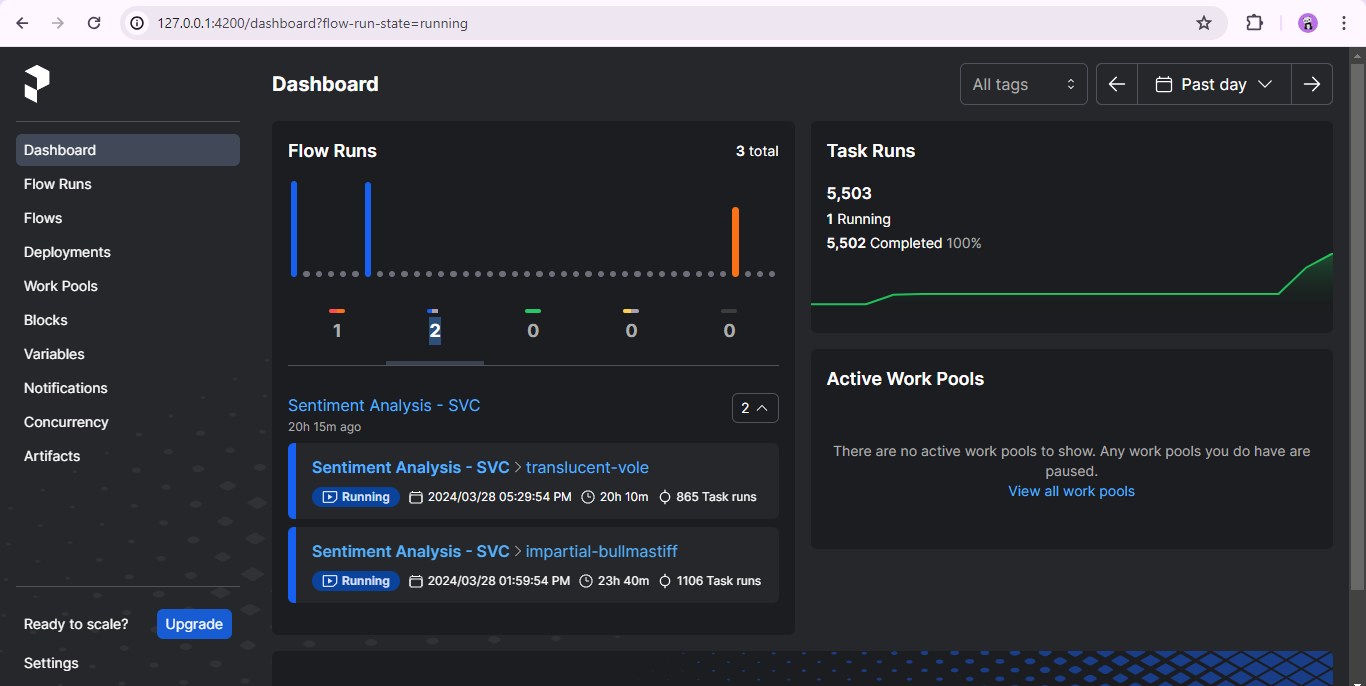

In [1]:

Image('screen/MLFlow & Prefect/prefect.png')